# **Train instance segmentation (YOLOv11)**

In [9]:
import torch

# CUDAが使えるかどうかを確認
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available! GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU


# **Extract_annotations**

cvat形式（xml）で抜き出したアノーテーションをyolo形式に直す

In [3]:
import os
import shutil


xml_path = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\annotations_1-139.xml"
label_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139"
start_id = 1
end_id = 500

# labels_dirが存在する場合、それを削除する
if os.path.exists(label_dir):
    print(f"ディレクトリ '{label_dir}' が存在します。削除します。")
    shutil.rmtree(label_dir)
    print(f"ディレクトリ '{label_dir}' を削除しました。")

# labels_dirを作成する
print(f"ディレクトリ '{label_dir}' を作成します。")
os.makedirs(label_dir)
print(f"ディレクトリ '{label_dir}' を作成しました。")




ディレクトリ 'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139' が存在します。削除します。
ディレクトリ 'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139' を削除しました。
ディレクトリ 'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139' を作成します。
ディレクトリ 'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139' を作成しました。


In [4]:

import xml.etree.ElementTree as ET
import os
import shutil

# CVAT形式のXMLアノテーションファイルを解析し、指定されたID範囲の画像について、
# ポリゴンアノテーションをYOLO形式（クラスID + 正規化された座標）に変換し、
# 対応する画像ファイル名を持つテキストファイルとして保存するスクリプト。

# --- Configuration ---
xml_path = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\annotations_1-139.xml"
label_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139"
start_id = 1   # Inclusive start image ID
end_id = 500   # Inclusive end image ID
# -------------------

# --- Directory Handling ---
# labels_dirが存在する場合、それを削除する
if os.path.exists(label_dir):
    print(f"ディレクトリ '{label_dir}' が存在します。削除します。")
    shutil.rmtree(label_dir)
    print(f"ディレクトリ '{label_dir}' を削除しました。")

# labels_dirを作成する
print(f"ディレクトリ '{label_dir}' を作成します。")
os.makedirs(label_dir)
print(f"ディレクトリ '{label_dir}' を作成しました。")



# --- XML Parsing and Conversion ---
try:
    print(f"Parsing XML file: {xml_path}")
    tree = ET.parse(xml_path)
    root = tree.getroot()
except FileNotFoundError:
    print(f"Error: XML file not found at {xml_path}")
    exit(1)
except ET.ParseError as e:
    print(f"Error parsing XML file: {e}")
    exit(1)

# 1. Create Label to ID mapping from the <labels> section
label_to_id = {}
label_elements = root.findall('.//meta/task/labels/label')
if not label_elements:
     label_elements = root.findall('.//labels/label') # Try alternative path if needed

if not label_elements:
    print("Warning: Could not find <label> elements in the XML meta section. Will build mapping dynamically.")
else:
    for idx, label_tag in enumerate(label_elements):
        name = label_tag.find('name').text
        if name not in label_to_id:
            label_to_id[name] = idx
            print(f"Mapped label '{name}' to class ID {idx}")

id_counter = len(label_to_id) # Start dynamic mapping from the next available ID


print(f"\nProcessing images with ID from {start_id} to {end_id}...")
images_processed = 0
images_skipped_out_of_range = 0

# 2. Iterate through images and process annotations
for image in root.findall('.//image'):
    image_id_str = image.get('id')
    image_name = image.get('name')
    width_str = image.get('width')
    height_str = image.get('height')

    if not all([image_id_str, image_name, width_str, height_str]):
        print(f"Warning: Skipping image entry due to missing attributes (id, name, width, or height).")
        continue

    try:
        image_id = int(image_id_str)
        img_width = int(width_str)
        img_height = int(height_str)
    except ValueError:
        print(f"Warning: Skipping image '{image_name}' due to invalid numeric attribute (id, width, or height).")
        continue

    # Check if image ID is within the desired range
    if not (start_id <= image_id <= end_id):
        images_skipped_out_of_range += 1
        continue

    if img_width <= 0 or img_height <= 0:
        print(f"Warning: Skipping image '{image_name}' (ID: {image_id}) due to zero or negative width/height ({img_width}x{img_height}).")
        continue

    # Prepare output file path
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    output_txt_path = os.path.join(label_dir, f"{base_name}.txt")
    yolo_annotations = []

    # Process polygons for the current image
    for polygon in image.findall('.//polygon'):
        label = polygon.get('label')
        points_str = polygon.get('points')

        if not label or not points_str:
            print(f"Warning: Skipping polygon in image '{image_name}' (ID: {image_id}) due to missing label or points.")
            continue

        # Assign class ID, dynamically add if not seen before
        if label not in label_to_id:
             if not label_elements: # Only add dynamically if initial mapping failed
                 label_to_id[label] = id_counter
                 print(f"Dynamically mapped new label '{label}' to class ID {id_counter}")
                 id_counter += 1
             else:
                 print(f"Warning: Label '{label}' found in image '{image_name}' (ID: {image_id}) but not defined in <labels> section. Skipping this polygon.")
                 continue # Skip if label mapping should be strict based on <labels>

        class_id = label_to_id[label]

        # Parse and normalize points
        normalized_points = []
        try:
            point_pairs = points_str.split(';')
            if len(point_pairs) < 3: # A polygon needs at least 3 points
                 print(f"Warning: Skipping polygon with label '{label}' in image '{image_name}' (ID: {image_id}) - less than 3 points ({len(point_pairs)} points found).")
                 continue

            for pair in point_pairs:
                x_str, y_str = pair.split(',')
                x = float(x_str)
                y = float(y_str)

                # Clamp coordinates to be within image bounds before normalizing
                x = max(0.0, min(x, img_width))
                y = max(0.0, min(y, img_height))

                norm_x = x / img_width
                norm_y = y / img_height
                normalized_points.extend([f"{norm_x:.6f}", f"{norm_y:.6f}"]) # Format with 6 decimal places

        except ValueError:
            print(f"Warning: Skipping polygon with label '{label}' in image '{image_name}' (ID: {image_id}) due to invalid point format in '{points_str}'.")
            continue
        except Exception as e:
             print(f"Warning: Skipping polygon with label '{label}' in image '{image_name}' (ID: {image_id}) due to error processing points '{points_str}': {e}")
             continue

        # Format the YOLO line
        yolo_line = f"{class_id} {' '.join(normalized_points)}"
        yolo_annotations.append(yolo_line)

    # Write annotations to the output file
    if yolo_annotations:
        try:
            with open(output_txt_path, 'w') as f:
                for line in yolo_annotations:
                    f.write(line + '\n')
            images_processed += 1
            if images_processed % 50 == 0: # Print progress every 50 images
                 print(f"  Processed {images_processed} images...")
        except IOError as e:
            print(f"Error writing to file {output_txt_path}: {e}")
    # else:
        # Optionally print a message if an image in range had no valid annotations
        # print(f"Image '{image_name}' (ID: {image_id}) had no valid polygons to write.")


# --- Final Summary ---
print("\n--- Conversion Summary ---")
print(f"Total images processed and files created: {images_processed}")
print(f"Total images skipped (outside ID range {start_id}-{end_id}): {images_skipped_out_of_range}")
print(f"Label mapping used: {label_to_id}")
print(f"Output files saved in: {label_dir}")
print("--------------------------")

ディレクトリ 'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139' が存在します。削除します。
ディレクトリ 'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139' を削除しました。
ディレクトリ 'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139' を作成します。
ディレクトリ 'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139' を作成しました。
Parsing XML file: C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\annotations_1-139.xml
Mapped label 'Eyelid' to class ID 0
Mapped label 'Caruncle' to class ID 1

Processing images with ID from 1 to 500...
  Processed 50 images...
  Processed 100 images...
  Processed 150 images...
  Processed 200 images...
  Processed 250 images...
  Processed 300 images...
  Processed 350 images...
  Processed 400 images...
  Processed 450 images...

--- Conversion Summary ---
Total images processed and files created: 497
Total images skipped (outside ID range 1-500): 3967
Label mapping used: {'Eyelid': 0, 'Caruncle':


ランダムに選択されたラベルファイル '102-20000814-8-152923_85dbf3f26d6bbb691d31f90d5903063afde1de3684bb4ccc8056e9bcaea285ef_R.txt' に対応する画像とアノテーションを元の解像度で表示します:


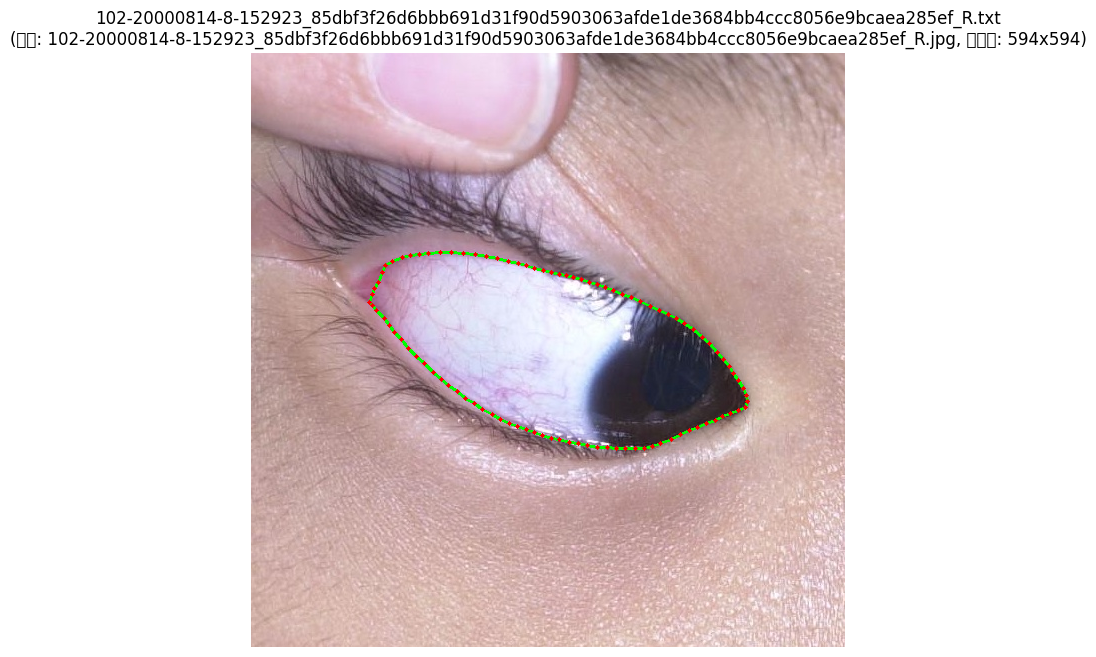

  - 102-20000814-8-152923_85dbf3f26d6bbb691d31f90d5903063afde1de3684bb4ccc8056e9bcaea285ef_R.txt: 表示完了 (画像: 102-20000814-8-152923_85dbf3f26d6bbb691d31f90d5903063afde1de3684bb4ccc8056e9bcaea285ef_R.jpg)


In [13]:
# YOLO形式のアノテーションが正しく付与されているか、ランダムに選択した画像とラベルで確認する
# (指定された画像ディレクトリとラベルディレクトリからランダムに1つの画像と対応するアノテーションを選択し、元の解像度で表示する)

images_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
label_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139"
# ライブラリのインポート (実際のコードでは上位セルにあると仮定)
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib # matplotlibのインポートを追加 (dpi取得のため)

# ラベルファイルリストの取得とエラーハンドリング
try:
    if not os.path.isdir(images_dir):
        print(f"エラー: 画像ディレクトリ '{images_dir}' が見つかりません。")
    elif not os.path.isdir(label_dir):
        print(f"エラー: ラベルディレクトリ '{label_dir}' が見つかりません。")
    else:
        label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
        if not label_files:
            print(f"エラー: ラベルディレクトリ '{label_dir}' に .txt ファイルが見つかりません。")
        else:
            # ランダムに1つのファイルを選択
            selected_label_filename = random.choice(label_files)
            print(f"\nランダムに選択されたラベルファイル '{selected_label_filename}' に対応する画像とアノテーションを元の解像度で表示します:")

            label_path = os.path.join(label_dir, selected_label_filename)
            image_filename_base = os.path.splitext(selected_label_filename)[0]

            # --- 対応する画像ファイルの検索 ---
            possible_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'] # 一般的な拡張子
            image_path = None
            for ext in possible_image_extensions:
                potential_path = os.path.join(images_dir, image_filename_base + ext)
                if os.path.exists(potential_path):
                    image_path = potential_path
                    break

            # --- 画像の読み込みとエラー処理 ---
            if image_path is None:
                print(f"  - {selected_label_filename}: 対応する画像ファイルが '{images_dir}' 内に見つかりませんでした。")
            else:
                img = cv2.imread(image_path)
                if img is None:
                    print(f"  - {selected_label_filename}: 画像ファイル '{os.path.basename(image_path)}' の読み込みに失敗しました。")
                else:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    h, w, _ = img.shape

                    # --- アノテーションの読み込みと描画 ---
                    annotations_drawn = False
                    lines = [] # 初期化
                    try:
                        if os.path.exists(label_path):
                            with open(label_path, 'r') as f:
                                lines = f.readlines()

                            if not lines:
                                print(f"  - {selected_label_filename}: ラベルファイルは空です。画像のみ表示します。")
                            else:
                                for line_num, line in enumerate(lines):
                                    parts = line.strip().split()
                                    # class_id + 少なくとも3点の座標 (x,y) が必要 (合計7要素以上)
                                    # かつ、座標の数は偶数である必要がある (x,yペア)
                                    if len(parts) < 7 or len(parts[1:]) % 2 != 0:
                                        print(f"    警告 ({selected_label_filename} 行 {line_num+1}): 不正な形式 '{line.strip()}'。スキップします。")
                                        continue

                                    # class_id = int(parts[0]) # 必要であればクラスごとに色分けなどに使用
                                    try:
                                        normalized_coords = np.array([float(p) for p in parts[1:]])
                                    except ValueError:
                                        print(f"    警告 ({selected_label_filename} 行 {line_num+1}): 座標に数値以外の値が含まれています。スキップします。")
                                        continue

                                    # 座標の非正規化
                                    points = []
                                    for j in range(0, len(normalized_coords), 2):
                                        nx = normalized_coords[j]
                                        ny = normalized_coords[j+1]
                                        # 座標が[0, 1]の範囲にあることを想定。範囲外ならクリップ。
                                        x = int(np.clip(nx, 0.0, 1.0) * w)
                                        y = int(np.clip(ny, 0.0, 1.0) * h)
                                        # 画像境界ギリギリの座標にならないように調整 (オプション)
                                        x = min(x, w - 1)
                                        y = min(y, h - 1)
                                        points.append([x, y])

                                    if len(points) < 3:
                                        print(f"    警告 ({selected_label_filename} 行 {line_num+1}): ポリゴン座標が3点未満。スキップします。")
                                        continue

                                    pts = np.array(points, np.int32)
                                    pts = pts.reshape((-1, 1, 2))

                                    # ポリゴンの輪郭を描画 (緑色、太さ2)
                                    line_thickness = 2 # 線の太さを変数化
                                    line_color = (0, 255, 0) # BGRではなくRGBなので緑
                                    cv2.polylines(img_rgb, [pts], isClosed=True, color=line_color, thickness=line_thickness)

                                    # --- 追加：各座標点を赤で描画 ---
                                    point_color = (255, 0, 0) # RGBで赤
                                    point_radius = line_thickness # 半径を線の太さと同じにする (円なので直径は線の太さの2倍)
                                    for point in points:
                                        center_coordinates = tuple(point) # cv2.circleはタプルを要求
                                        # thickness=-1 で塗りつぶし円を描画
                                        cv2.circle(img_rgb, center_coordinates, point_radius, point_color, thickness=-1)
                                    # --- 追加ここまで ---

                                    annotations_drawn = True
                        else:
                             print(f"  - {selected_label_filename}: ラベルファイルが見つかりません。画像のみ表示します。")


                    except Exception as e:
                        print(f"  - {selected_label_filename}: ラベル処理中に予期せぬエラーが発生しました: {e}")
                        # エラーが発生しても、読み込めた画像は表示試行

                    # --- 元の解像度で画像の表示 ---
                    # matplotlibのデフォルトDPIを取得
                    dpi = matplotlib.rcParams['figure.dpi']
                    # 画像のピクセル数をインチに変換してfigsizeを設定
                    # これにより、表示される画像のピクセル数が元の画像のピクセル数と一致するようになります（縮小なし）
                    figsize = w / float(dpi), h / float(dpi)

                    plt.figure(figsize=figsize)
                    plt.imshow(img_rgb)

                    # タイトルの設定
                    title = f"{selected_label_filename}"
                    if annotations_drawn:
                        title += f"\n(画像: {os.path.basename(image_path)}, サイズ: {w}x{h})"
                    elif os.path.exists(label_path) and not lines: # ラベルファイルは空
                         title += f"\n(画像: {os.path.basename(image_path)}, サイズ: {w}x{h}, ラベル空)"
                    elif os.path.exists(label_path): # ラベルファイルはあるがエラー等で描画されなかった
                         title += f"\n(画像: {os.path.basename(image_path)}, サイズ: {w}x{h}, アノテーションエラー)"
                    else: # ラベルファイルが存在しない
                         title += f"\n(画像: {os.path.basename(image_path)}, サイズ: {w}x{h}, ラベルなし)"

                    plt.title(title)
                    plt.axis('off') # 軸を非表示
                    # plt.tight_layout() # tight_layoutはfigsize指定時は不要な場合が多い、または調整が必要
                    plt.subplots_adjust(left=0, right=1, top=1, bottom=0) # 余白を最小限に
                    plt.show()

                    if annotations_drawn:
                        print(f"  - {selected_label_filename}: 表示完了 (画像: {os.path.basename(image_path)})")
                    elif os.path.exists(label_path) and not lines:
                         print(f"  - {selected_label_filename}: 画像表示完了 (ラベルファイルは空)")
                    # その他のメッセージは描画前/描画中に表示済み

# NameErrorは上位セルで変数が定義されていない可能性を示す
except NameError as e:
    print(f"エラー: 変数が定義されていません: {e}。images_dir と label_dir がこのセルより前で正しく設定されているか確認してください。")
# ImportErrorはライブラリが利用できない場合
except ImportError as e:
    print(f"エラー: 必要なライブラリがインポートされていません: {e}。上位のセルで matplotlib, cv2, numpy, os, random を import してください。")
# その他の予期せぬエラー
except Exception as e:
    print(f"予期せぬエラーが発生しました: {e}")



ランダムに選択されたラベルファイル '135-20170802-6-094251_8b5d78fd03abdeceec67622990cd73a16af3ded193670ce9f19c7c87d5252570_L.txt' に対応する画像とアノテーションを元の解像度で表示します:


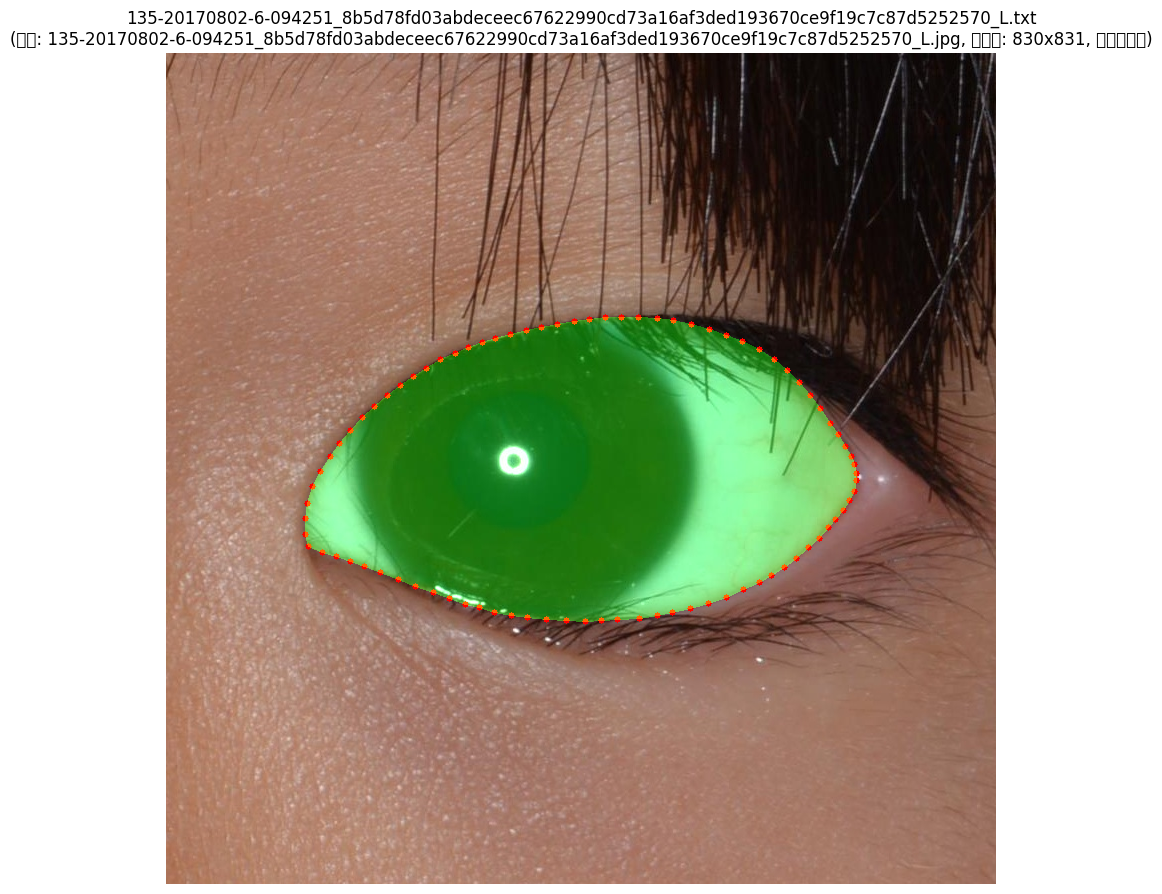

  - 135-20170802-6-094251_8b5d78fd03abdeceec67622990cd73a16af3ded193670ce9f19c7c87d5252570_L.txt: 表示完了 (画像: 135-20170802-6-094251_8b5d78fd03abdeceec67622990cd73a16af3ded193670ce9f19c7c87d5252570_L.jpg, マスク適用)


In [12]:
# YOLO形式のアノテーションが正しく付与されているか、ランダムに選択した画像とラベルで確認する
# (指定された画像ディレクトリとラベルディレクトリからランダムに1つの画像と対応するアノテーションを選択し、元の解像度で表示する)

images_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
label_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139"
# ライブラリのインポート (実際のコードでは上位セルにあると仮定)
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib # matplotlibのインポートを追加 (dpi取得のため)

# ラベルファイルリストの取得とエラーハンドリング
try:
    if not os.path.isdir(images_dir):
        print(f"エラー: 画像ディレクトリ '{images_dir}' が見つかりません。")
    elif not os.path.isdir(label_dir):
        print(f"エラー: ラベルディレクトリ '{label_dir}' が見つかりません。")
    else:
        label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
        if not label_files:
            print(f"エラー: ラベルディレクトリ '{label_dir}' に .txt ファイルが見つかりません。")
        else:
            # ランダムに1つのファイルを選択
            selected_label_filename = random.choice(label_files)
            print(f"\nランダムに選択されたラベルファイル '{selected_label_filename}' に対応する画像とアノテーションを元の解像度で表示します:")

            label_path = os.path.join(label_dir, selected_label_filename)
            image_filename_base = os.path.splitext(selected_label_filename)[0]

            # --- 対応する画像ファイルの検索 ---
            possible_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'] # 一般的な拡張子
            image_path = None
            for ext in possible_image_extensions:
                potential_path = os.path.join(images_dir, image_filename_base + ext)
                if os.path.exists(potential_path):
                    image_path = potential_path
                    break

            # --- 画像の読み込みとエラー処理 ---
            if image_path is None:
                print(f"  - {selected_label_filename}: 対応する画像ファイルが '{images_dir}' 内に見つかりませんでした。")
            else:
                img = cv2.imread(image_path)
                if img is None:
                    print(f"  - {selected_label_filename}: 画像ファイル '{os.path.basename(image_path)}' の読み込みに失敗しました。")
                else:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    h, w, _ = img.shape
                    img_overlay = img_rgb.copy() # 描画用に画像をコピー

                    # --- アノテーションの読み込みと描画 ---
                    annotations_drawn = False # 何か描画されたかを示すフラグ
                    mask = np.zeros_like(img_rgb, dtype=np.uint8) # マスク用の黒画像を作成
                    lines = [] # 初期化
                    try:
                        if os.path.exists(label_path):
                            with open(label_path, 'r') as f:
                                lines = f.readlines()

                            if not lines:
                                print(f"  - {selected_label_filename}: ラベルファイルは空です。画像のみ表示します。")
                            else:
                                for line_num, line in enumerate(lines):
                                    parts = line.strip().split()
                                    # class_id + 少なくとも3点の座標 (x,y) が必要 (合計7要素以上)
                                    # かつ、座標の数は偶数である必要がある (x,yペア)
                                    if len(parts) < 7 or len(parts[1:]) % 2 != 0:
                                        print(f"    警告 ({selected_label_filename} 行 {line_num+1}): 不正な形式 '{line.strip()}'。スキップします。")
                                        continue

                                    # class_id = int(parts[0]) # 必要であればクラスごとに色分けなどに使用
                                    try:
                                        normalized_coords = np.array([float(p) for p in parts[1:]])
                                    except ValueError:
                                        print(f"    警告 ({selected_label_filename} 行 {line_num+1}): 座標に数値以外の値が含まれています。スキップします。")
                                        continue

                                    # 座標の非正規化
                                    points = []
                                    for j in range(0, len(normalized_coords), 2):
                                        nx = normalized_coords[j]
                                        ny = normalized_coords[j+1]
                                        # 座標が[0, 1]の範囲にあることを想定。範囲外ならクリップ。
                                        x = int(np.clip(nx, 0.0, 1.0) * w)
                                        y = int(np.clip(ny, 0.0, 1.0) * h)
                                        # 画像境界ギリギリの座標にならないように調整 (オプション)
                                        x = min(x, w - 1)
                                        y = min(y, h - 1)
                                        points.append([x, y])

                                    if len(points) < 3:
                                        print(f"    警告 ({selected_label_filename} 行 {line_num+1}): ポリゴン座標が3点未満。スキップします。")
                                        continue

                                    pts = np.array(points, np.int32)
                                    pts = pts.reshape((-1, 1, 2)) # drawContoursが必要とする形式に変換

                                    # --- マスクの作成 (drawContoursで塗りつぶし) ---
                                    mask_color = (0, 255, 0) # マスクの色 (緑)
                                    cv2.drawContours(mask, [pts], contourIdx=-1, color=mask_color, thickness=cv2.FILLED)
                                    # --- マスク作成ここまで ---

                                    # --- 輪郭線の描画 (オプションとして追加) ---
                                    # line_thickness = 2 # 線の太さ
                                    # line_color = (0, 255, 0) # 輪郭の色 (緑)
                                    # cv2.drawContours(img_overlay, [pts], contourIdx=-1, color=line_color, thickness=line_thickness)
                                    # --- 輪郭線ここまで ---

                                    # --- 各座標点を赤で描画 ---
                                    point_color = (255, 0, 0) # RGBで赤
                                    point_radius = 3 # 半径を少し大きく
                                    for point in points:
                                        center_coordinates = tuple(point) # cv2.circleはタプルを要求
                                        # thickness=-1 で塗りつぶし円を描画
                                        cv2.circle(img_overlay, center_coordinates, point_radius, point_color, thickness=-1)
                                    # --- 追加ここまで ---

                                    annotations_drawn = True # 有効なアノテーションが処理された

                                # --- マスクを画像にオーバーレイ ---
                                if annotations_drawn:
                                    alpha = 0.4 # マスクの透明度
                                    img_overlay = cv2.addWeighted(img_overlay, 1, mask, alpha, 0)
                                # --- オーバーレイここまで ---

                        else:
                             print(f"  - {selected_label_filename}: ラベルファイルが見つかりません。画像のみ表示します。")


                    except Exception as e:
                        print(f"  - {selected_label_filename}: ラベル処理中に予期せぬエラーが発生しました: {e}")
                        # エラーが発生しても、読み込めた画像は表示試行 (img_overlayは元の画像のまま)

                    # --- 元の解像度で画像の表示 ---
                    # matplotlibのデフォルトDPIを取得
                    dpi = matplotlib.rcParams['figure.dpi']
                    # 画像のピクセル数をインチに変換してfigsizeを設定
                    figsize = w / float(dpi), h / float(dpi)

                    plt.figure(figsize=figsize)
                    # マスクが適用された画像 (img_overlay) を表示
                    plt.imshow(img_overlay)

                    # タイトルの設定
                    title = f"{selected_label_filename}"
                    if annotations_drawn:
                        title += f"\n(画像: {os.path.basename(image_path)}, サイズ: {w}x{h}, マスク表示)"
                    elif os.path.exists(label_path) and not lines: # ラベルファイルは空
                         title += f"\n(画像: {os.path.basename(image_path)}, サイズ: {w}x{h}, ラベル空)"
                    elif os.path.exists(label_path): # ラベルファイルはあるがエラー等で描画されなかった
                         title += f"\n(画像: {os.path.basename(image_path)}, サイズ: {w}x{h}, アノテーションエラー)"
                    else: # ラベルファイルが存在しない
                         title += f"\n(画像: {os.path.basename(image_path)}, サイズ: {w}x{h}, ラベルなし)"

                    plt.title(title)
                    plt.axis('off') # 軸を非表示
                    plt.subplots_adjust(left=0, right=1, top=1, bottom=0) # 余白を最小限に
                    plt.show()

                    if annotations_drawn:
                        print(f"  - {selected_label_filename}: 表示完了 (画像: {os.path.basename(image_path)}, マスク適用)")
                    elif os.path.exists(label_path) and not lines:
                         print(f"  - {selected_label_filename}: 画像表示完了 (ラベルファイルは空)")
                    # その他のメッセージは描画前/描画中に表示済み

# NameErrorは上位セルで変数が定義されていない可能性を示す
except NameError as e:
    print(f"エラー: 変数が定義されていません: {e}。images_dir と label_dir がこのセルより前で正しく設定されているか確認してください。")
# ImportErrorはライブラリが利用できない場合
except ImportError as e:
    print(f"エラー: 必要なライブラリがインポートされていません: {e}。上位のセルで matplotlib, cv2, numpy, os, random を import してください。")
# その他の予期せぬエラー
except Exception as e:
    print(f"予期せぬエラーが発生しました: {e}")


In [ ]:
# Maskの検証用（コード再構成後は削除可）

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib # Import matplotlib itself
from pathlib import Path

def resample_segments(segments, n=1000):
    """
    Replicates Ultralytics' resample_segments function.
    Resamples segments to n points.
    """
    resampled = []
    for segment in segments:
        segment = np.array(segment)
        x = np.linspace(0, len(segment) - 1, n)
        xp = np.arange(len(segment))

        # Interpolate for resampling
        p = np.interp(x, xp, segment[:, 0])  # Interpolate x coordinates
        q = np.interp(x, xp, segment[:, 1])  # Interpolate y coordinates

        # Store resampled points
        resampled.append(np.stack([p, q], axis=1))
    return resampled

def segments2boxes(segments):
    """
    Replicates Ultralytics' segments2boxes function.
    Generates bounding boxes from segments.
    """
    boxes = []
    for segment in segments:
        x, y = segment.T  # Get x and y coordinates of the segment
        boxes.append([x.min(), y.min(), x.max(), y.max()])  # xmin, ymin, xmax, ymax
    return np.array(boxes)

def read_yolo_segmentation_label(label_path):
    """Reads YOLO format segmentation labels."""
    segments = []
    classes = []

    try:
        with open(label_path, 'r') as f:
            for line in f:
                values = line.strip().split()
                if len(values) < 3: # Need at least class_id and one point (x, y)
                    print(f"Warning: Skipping invalid line in {label_path}: {line.strip()}")
                    continue
                try:
                    class_id = int(values[0])
                    coords = values[1:]  # x1 y1 x2 y2 ... xn yn

                    # Convert coordinates to floats
                    coords = [float(c) for c in coords]

                    # Convert to coordinate pairs
                    segment = []
                    if len(coords) % 2 != 0:
                         print(f"Warning: Skipping line with odd number of coordinates in {label_path}: {line.strip()}")
                         continue
                    for i in range(0, len(coords), 2):
                        segment.append([coords[i], coords[i + 1]])

                    if len(segment) < 3: # A polygon needs at least 3 points
                         print(f"Warning: Skipping segment with less than 3 points in {label_path}: {line.strip()}")
                         continue

                    segments.append(np.array(segment))
                    classes.append(class_id)
                except ValueError as e:
                    print(f"Warning: Skipping line with invalid numeric value in {label_path}: {line.strip()} - Error: {e}")
                    continue

    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return [], []
    except Exception as e:
        print(f"Error reading label file {label_path}: {e}")
        return [], []

    return segments, classes


def generate_mask_from_segments(image_shape, segments, normalized=True,
                               apply_resampling=False, n_points=1000,
                               restrict_to_bbox=False):
    """
    Generates a mask from segment coordinates, optionally applying resampling and bounding box restriction.
    Returns the mask, original segments (pixel coords), and processed segments (pixel coords).
    """
    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    # Store segments converted to pixel coordinates
    original_segments_pixels = []
    processed_segments_pixels = []

    # Determine which segments to use for mask generation
    segments_to_process = segments
    if apply_resampling:
        segments_to_process = resample_segments(segments, n=n_points)

    # Calculate bounding boxes if needed (using the segments that will be used for the mask)
    bboxes_pixels = None
    if restrict_to_bbox:
        bboxes_normalized = segments2boxes(segments_to_process) # BBoxes from potentially resampled segments
        bboxes_pixels = bboxes_normalized.copy()
        if normalized:
            bboxes_pixels[:, [0, 2]] *= width
            bboxes_pixels[:, [1, 3]] *= height
        bboxes_pixels = bboxes_pixels.astype(np.int32)
        # Clip boxes to image boundaries
        bboxes_pixels[:, [0, 2]] = np.clip(bboxes_pixels[:, [0, 2]], 0, width)
        bboxes_pixels[:, [1, 3]] = np.clip(bboxes_pixels[:, [1, 3]], 0, height)


    # Generate mask for each segment
    for i, segment_norm in enumerate(segments): # Iterate through original segments for consistency
        # --- Get original segment in pixel coordinates ---
        orig_segment_pixels = segment_norm.copy()
        if normalized:
            orig_segment_pixels[:, 0] *= width
            orig_segment_pixels[:, 1] *= height
        original_segments_pixels.append(orig_segment_pixels.astype(np.int32))

        # --- Get processed segment (potentially resampled) in pixel coordinates ---
        processed_segment_norm = segments_to_process[i]
        processed_segment_pixels = processed_segment_norm.copy()
        if normalized:
            processed_segment_pixels[:, 0] *= width
            processed_segment_pixels[:, 1] *= height
        processed_segment_pixels = processed_segment_pixels.astype(np.int32)
        processed_segments_pixels.append(processed_segment_pixels)

        # --- Draw polygon on mask ---
        points_to_draw = processed_segment_pixels # Use potentially resampled points for mask

        if len(points_to_draw) < 3: # cv2.fillPoly needs at least 3 points
            continue

        if restrict_to_bbox and bboxes_pixels is not None:
            xmin, ymin, xmax, ymax = bboxes_pixels[i]
            # Ensure bbox has valid area
            if xmin >= xmax or ymin >= ymax:
                continue

            # Create a temporary mask for the current polygon within its bbox
            # Offset points relative to the bbox top-left corner
            roi_points = points_to_draw - [xmin, ymin]
            # Create ROI mask slightly larger if points are exactly on boundary? No, fillPoly handles it.
            roi_h, roi_w = ymax - ymin, xmax - xmin
            roi_mask = np.zeros((roi_h, roi_w), dtype=np.uint8)
            cv2.fillPoly(roi_mask, [roi_points], 255)

            # Place the ROI mask onto the main mask
            mask[ymin:ymax, xmin:xmax] = cv2.bitwise_or(mask[ymin:ymax, xmin:xmax], roi_mask)

        else:
            # Draw directly on the main mask
            cv2.fillPoly(mask, [points_to_draw], 255)

    return mask, original_segments_pixels, processed_segments_pixels


def visualize_yolo_processing(image_path, label_path):
    """Visualizes each step of YOLO segmentation processing."""
    # Load image
    image = cv2.imread(str(image_path)) # Use str() for Path objects if necessary
    if image is None:
        print(f"Could not load image: {image_path}")
        return
    height, width = image.shape[:2]

    # Convert BGR -> RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load labels
    segments_norm, classes = read_yolo_segmentation_label(label_path)

    if not segments_norm:
        print(f"No segmentation data found or loaded from: {label_path}")
        # Optionally display the image anyway
        plt.figure(figsize=(10,10))
        plt.imshow(image_rgb)
        plt.title(f'Original Image (No Segments Found)\n{Path(image_path).name}')
        plt.axis('off')
        plt.show()
        return

    # --- Generate Masks ---
    # Note: generate_mask_from_segments now returns segments in pixel coordinates
    normal_mask, orig_segments_px, _ = generate_mask_from_segments(
        image.shape, segments_norm, normalized=True, apply_resampling=False)

    resampled_mask, _, resampled_segments_px = generate_mask_from_segments(
        image.shape, segments_norm, normalized=True, apply_resampling=True, n_points=1000)

    bbox_mask, _, _ = generate_mask_from_segments( # Use original segments for bbox mask base
        image.shape, segments_norm, normalized=True, apply_resampling=False, restrict_to_bbox=True)

    full_processed_mask, _, _ = generate_mask_from_segments( # Use resampled segments for full processed mask base
        image.shape, segments_norm, normalized=True, apply_resampling=True, n_points=1000, restrict_to_bbox=True)


    # --- Create Overlays ---
    def create_overlay(img, msk, color=(0, 255, 0), alpha=0.5):
        colored_mask = np.zeros_like(img)
        colored_mask[msk > 0] = color
        # Ensure overlay respects image boundaries implicitly by using img shape
        return cv2.addWeighted(img, 1, colored_mask, alpha, 0)

    normal_overlay = create_overlay(image_rgb, normal_mask)
    resampled_overlay = create_overlay(image_rgb, resampled_mask)
    bbox_overlay = create_overlay(image_rgb, bbox_mask)
    full_processed_overlay = create_overlay(image_rgb, full_processed_mask)

    # --- Display Results ---

    # Calculate figsize for original resolution display (helper function)
    def get_figsize(img_h, img_w):
        dpi = matplotlib.rcParams['figure.dpi']
        figsize = img_w / float(dpi), img_h / float(dpi)
        return figsize

    # 1. Original Image
    plt.figure(figsize=get_figsize(height, width))
    plt.imshow(image_rgb)
    plt.title(f'Original Image\n{Path(image_path).name}')
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0) # Adjust top for title
    plt.show()

    # 2. Original Annotations
    annotation_vis = image_rgb.copy()
    for points in orig_segments_px: # Use pixel coordinates directly
        # Draw original annotation points and lines
        for i, point in enumerate(points):
            cv2.circle(annotation_vis, tuple(point), 3, (255, 0, 0), -1) # Red dots
            if i > 0:
                cv2.line(annotation_vis, tuple(points[i-1]), tuple(point), (0, 0, 255), 1) # Blue lines
        # Draw polygon outline
        cv2.polylines(annotation_vis, [points], isClosed=True, color=(0, 255, 0), thickness=1) # Green outline

    plt.figure(figsize=get_figsize(height, width))
    plt.imshow(annotation_vis)
    plt.title('Original Annotations (Pixel Coords)')
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
    plt.show()

    # 3. Resampled Annotations (Points only, sparse)
    resampled_vis = image_rgb.copy()
    for points in resampled_segments_px: # Use pixel coordinates directly
        # Draw resampled points (sparse)
        for i, point in enumerate(points):
            if i % 50 == 0:  # Show every 50th point
                cv2.circle(resampled_vis, tuple(point), 3, (0, 0, 255), -1) # Blue dots

    plt.figure(figsize=get_figsize(height, width))
    plt.imshow(resampled_vis)
    plt.title('Resampled Annotation Points (1000 points, sparse view)')
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
    plt.show()

    # 4. Masks (Displayed at original resolution)
    mask_titles = ['Normal Mask', 'Resampled Mask', 'BBox Restricted Mask', 'Resampled + BBox Mask']
    masks_to_show = [normal_mask, resampled_mask, bbox_mask, full_processed_mask]

    for mask_img, title in zip(masks_to_show, mask_titles):
        plt.figure(figsize=get_figsize(height, width))
        plt.imshow(mask_img, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
        plt.show()

    # 5. Overlays (Displayed at original resolution)
    overlay_titles = ['Normal Overlay', 'Resampled Overlay', 'BBox Restricted Overlay', 'Resampled + BBox Overlay']
    overlays_to_show = [normal_overlay, resampled_overlay, bbox_overlay, full_processed_overlay]

    for overlay_img, title in zip(overlays_to_show, overlay_titles):
        plt.figure(figsize=get_figsize(height, width))
        plt.imshow(overlay_img)
        plt.title(title)
        plt.axis('off')
        plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
        plt.show()


    # 6. Bounding Boxes (from original segments)
    bboxes_norm = segments2boxes(segments_norm) # Calculate from original normalized segments
    bboxes_vis = image_rgb.copy()

    for bbox in bboxes_norm:
        xmin, ymin, xmax, ymax = bbox
        # Convert normalized bbox to pixel coordinates
        xmin = int(xmin * width)
        ymin = int(ymin * height)
        xmax = int(xmax * width)
        ymax = int(ymax * height)

        # Clip boxes to image boundaries
        xmin, xmax = np.clip([xmin, xmax], 0, width)
        ymin, ymax = np.clip([ymin, ymax], 0, height)

        cv2.rectangle(bboxes_vis, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2) # Red rectangle

    plt.figure(figsize=get_figsize(height, width))
    plt.imshow(bboxes_vis)
    plt.title('Bounding Boxes (from original segments)')
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
    plt.show()

    # Return results (masks are numpy arrays, bboxes are normalized)
    return {
        'image': image_rgb,
        'normal_mask': normal_mask,
        'resampled_mask': resampled_mask,
        'bbox_mask': bbox_mask,
        'full_processed_mask': full_processed_mask,
        'bboxes_normalized': bboxes_norm # Return normalized bboxes
    }

# --- Execution ---
# Define paths (ensure these are correct)
image_path = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20111005-77-000000_11d30332302a60df073d17d2ebc5d641ca9adf0bf35c4315a5fbf2045150e51e_L.jpg"
label_path = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139\11-20111005-77-000000_11d30332302a60df073d17d2ebc5d641ca9adf0bf35c4315a5fbf2045150e51e_L.txt"
# Check if files exist before running
img_p = Path(image_path)
lbl_p = Path(label_path)

if not img_p.is_file():
    print(f"Image file not found: {image_path}")
elif not lbl_p.is_file():
     print(f"Label file not found: {label_path}")
else:
    # Execute the visualization
    results = visualize_yolo_processing(image_path, label_path)
    # You can access the results dictionary later if needed, e.g., results['normal_mask']
    if results:
        print("Visualization complete. Results dictionary contains image, masks, and normalized bounding boxes.")
    else:
        print("Visualization failed.")

選択されたラベルファイル: 136-20190821-15-090533_dd5d112b8f53b45b3964e0845947e3068010ba3dc5da2f94cce1e5f77aaaa4a4_R.txt
対応する画像ファイルが見つかりました: 136-20190821-15-090533_dd5d112b8f53b45b3964e0845947e3068010ba3dc5da2f94cce1e5f77aaaa4a4_R.jpg
画像サイズ (HxW): 968 x 967
  - 最後のポリゴンの座標 (21点):
    [[762, 479], [753, 486], [746, 492], [741, 498], [735, 506], [728, 516], [724, 525], [721, 533], [718, 541], [732, 539], [748, 538], [763, 536], [778, 535], [791, 535], [800, 535], [807, 534], [802, 525], [795, 517], [787, 506], [779, 497], [771, 489]]


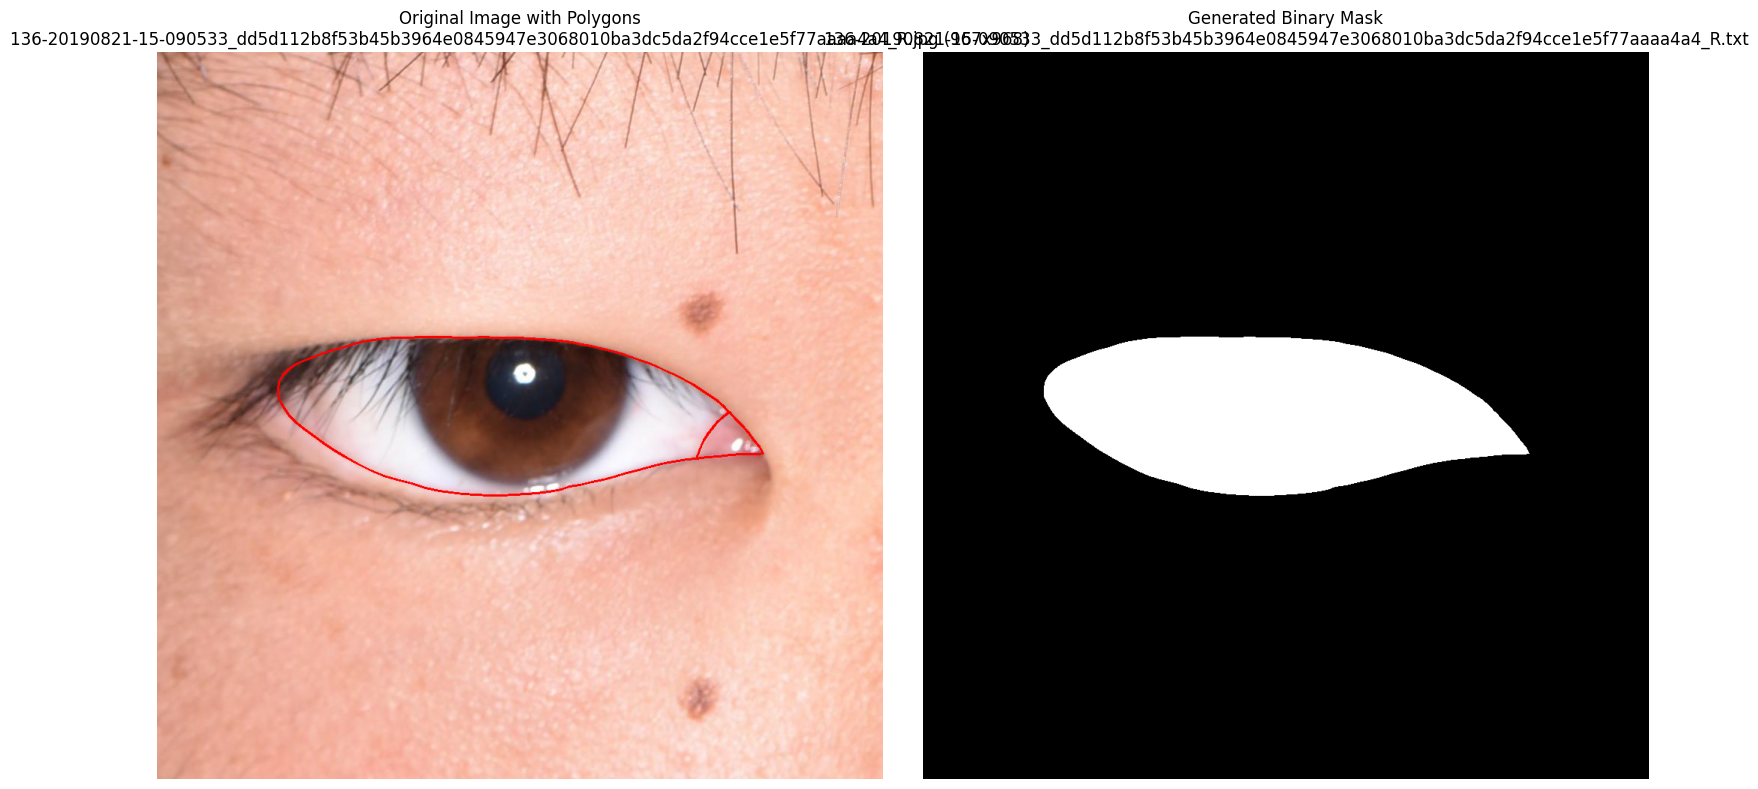

画像 '136-20190821-15-090533_dd5d112b8f53b45b3964e0845947e3068010ba3dc5da2f94cce1e5f77aaaa4a4_R.jpg' とそのマスク '136-20190821-15-090533_dd5d112b8f53b45b3964e0845947e3068010ba3dc5da2f94cce1e5f77aaaa4a4_R.txt' の表示を試みました。
  - 画像上にポリゴンを描画しました。


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib # matplotlib自体もインポートしておく
import traceback # tracebackをインポート

# ultralytics.data.utils が存在するか確認
try:
    from ultralytics.data.utils import polygon2mask
    # ユーザーの指示には convert_segment_masks_to_yolo_seg がありましたが、
    # これはマスクファイル群をYOLO形式のラベルファイルに変換するもので、
    # メモリ上のマスクから座標を生成してプロットする目的には直接使用しません。
    # プロットには元のラベルファイルから読み取った座標を使用します。
    # from ultralytics.data.converter import convert_segment_masks_to_yolo_seg # プロットには不要
except ImportError:
    print("エラー: 'ultralytics' ライブラリが見つからないか、'polygon2mask' をインポートできませんでした。")
    print("pip install ultralytics を実行してインストールしてください。")
    # polygon2maskをNoneに設定するか、例外を再発生させて以降の実行を停止
    polygon2mask = None

# --- ディレクトリ設定 ---
# 注意: これらのディレクトリはこのセルまたは前のセルで定義されている必要があります。
# ここではプレースホルダー値を設定し、存在しない場合にエラーチェックを行います。
try:
    # images_dir と label_dir が前のセルで定義されていることを期待
    if 'images_dir' not in locals() or 'label_dir' not in locals():
         # 未定義の場合、ここで定義（例：セル8からコピー）
         images_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
         label_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139"
         print("情報: images_dir と label_dir はこのセルで定義されました。")

    # ディレクトリが存在するか確認
    if not os.path.isdir(images_dir):
        raise FileNotFoundError(f"画像ディレクトリが見つかりません: {images_dir}")
    if not os.path.isdir(label_dir):
        raise FileNotFoundError(f"ラベルディレクトリが見つかりません: {label_dir}")

    # polygon2maskがインポートできなかった場合は処理を停止
    if polygon2mask is None:
        raise ImportError("ultralytics.data.utils.polygon2mask のインポートに失敗しました。")

    # --- 1. ランダムなラベルファイルを選択 ---
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    if not label_files:
        print(f"エラー: ラベルディレクトリ '{label_dir}' にラベルファイル (.txt) が見つかりません。")
    else:
        selected_label_filename = random.choice(label_files)
        label_path = os.path.join(label_dir, selected_label_filename)
        base_filename = os.path.splitext(selected_label_filename)[0]
        print(f"選択されたラベルファイル: {selected_label_filename}")

        # --- 2. 対応する画像ファイルを探す ---
        image_path = None
        possible_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']
        for ext in possible_extensions:
            potential_image_path = os.path.join(images_dir, base_filename + ext)
            if os.path.exists(potential_image_path):
                image_path = potential_image_path
                print(f"対応する画像ファイルが見つかりました: {os.path.basename(image_path)}")
                break

        if image_path is None:
            print(f"エラー: ラベル '{selected_label_filename}' に対応する画像ファイルがディレクトリ '{images_dir}' に見つかりませんでした。")
            print(f"(検索した拡張子: {', '.join(possible_extensions)})")
        else:
            # --- 3. 画像を読み込む ---
            img = cv2.imread(image_path)
            if img is None:
                print(f"エラー: 画像ファイル '{image_path}' の読み込みに失敗しました。破損しているか、サポートされていない形式の可能性があります。")
            else:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                h, w = img.shape[:2]
                imgsz = (h, w) # polygon2mask用の画像サイズ (高さ, 幅)
                print(f"画像サイズ (HxW): {h} x {w}")

                # --- 4. ラベルからバイナリマスクとポリゴンを生成 ---
                combined_mask = np.zeros(imgsz, dtype=np.uint8) # 結合マスクを初期化 (8ビット)
                img_with_polygons = img_rgb.copy() # ポリゴン描画用の画像コピーを作成
                polygons_drawn = False
                annotations_found = False # 有効なアノテーションが見つかったか
                last_polygon_abs = None # 最後のポリゴンの絶対座標を格納する変数
                last_polygon_point_count = 0 # 最後のポリゴンの点の数を格納する変数

                try:
                    with open(label_path, 'r') as f:
                        lines = f.readlines()

                    if not lines:
                         print(f"情報: ラベルファイル '{selected_label_filename}' は空です。マスクは生成されず、ポリゴンも描画されません。")

                    for i, line in enumerate(lines):
                        parts = line.strip().split()
                        # クラスID + 少なくとも3点 (x1 y1 x2 y2 x3 y3 ...) が必要
                        if len(parts) >= 7 and len(parts) % 2 == 1:
                            annotations_found = True
                            try:
                                # クラスIDと正規化座標を抽出
                                class_id = int(parts[0]) # クラスIDも取得（今回は使わないが将来的に利用可能）
                                coords_norm = np.array([float(p) for p in parts[1:]])

                                # 座標を (N, 2) にリシェイプし、絶対座標に変換
                                polygon_norm = coords_norm.reshape(-1, 2)
                                polygon_abs = polygon_norm * np.array([w, h])
                                polygon_abs = polygon_abs.astype(np.int32) # polygon2mask と cv2.polylines は整数座標を期待

                                # --- 最後のポリゴン情報を更新 ---
                                last_polygon_abs = polygon_abs
                                last_polygon_point_count = len(polygon_abs) # 点の数 (N)

                                # --- このポリゴンを画像に描画 ---
                                # 色をランダムに選択（またはクラスごとに固定色を設定）
                                # color = tuple(np.random.randint(0, 256, 3).tolist()) # BGRではなくRGBなので注意
                                color = (255, 0, 0) # 例: 赤色で描画 (RGB)
                                cv2.polylines(img_with_polygons, [polygon_abs], isClosed=True, color=color, thickness=2)
                                polygons_drawn = True

                                # --- このポリゴンのマスクを生成 ---
                                single_polygon_mask = polygon2mask(
                                    imgsz,          # 画像サイズ (h, w)
                                    [polygon_abs],  # ポリゴンのリストとして渡す
                                    color=255,      # 8ビットバイナリマスク (0 または 255)
                                    downsample_ratio=1, # ダウンサンプリングなし
                                )

                                # 生成されたマスクを結合マスクに合成 (ビット単位OR)
                                combined_mask = cv2.bitwise_or(combined_mask, single_polygon_mask)

                            except ValueError:
                                print(f"警告: ラベルファイル '{selected_label_filename}' の {i+1} 行目: 数値に変換できない座標が含まれています: '{line.strip()}'")
                            except Exception as poly_err:
                                print(f"警告: ラベルファイル '{selected_label_filename}' の {i+1} 行目の処理中にエラーが発生しました: {poly_err} ({line.strip()})")
                        elif len(parts) > 0: # 空行ではないが、形式が不正
                            print(f"警告: ラベルファイル '{selected_label_filename}' の {i+1} 行目: 不正な形式です (クラスID + 奇数個の座標が必要です): '{line.strip()}'")

                    # --- ループ終了後、最後のポリゴン情報を表示 ---
                    if last_polygon_abs is not None:
                        print(f"  - 最後のポリゴンの座標 ({last_polygon_point_count}点):")
                        # numpy配列をリストに変換して表示（見やすくするため）
                        print(f"    {last_polygon_abs.tolist()}")
                    elif annotations_found: # 有効なアノテーションはあったが、最後の座標が記録されなかった場合（通常は起こらないはず）
                        print("  - 有効なポリゴンは処理されましたが、最後の座標を取得できませんでした。")

                    if not annotations_found and lines:
                         print(f"情報: ラベルファイル '{selected_label_filename}' に有効なポリゴンアノテーションが見つかりませんでした。")

                    # --- 5. 元画像（ポリゴン描画付き）と生成されたマスクを表示 ---
                    # matplotlibのデフォルトDPIを取得
                    dpi = matplotlib.rcParams['figure.dpi']
                    # 画像のピクセルサイズをインチに変換してfigsizeを設定（ほぼ元の解像度での表示を目指す）
                    # ただし、画面サイズの制限を考慮して最大サイズを制限
                    base_figsize_w = w / float(dpi)
                    base_figsize_h = h / float(dpi)
                    # 2つのプロットを横に並べるために幅を2倍にする。大きすぎる場合は調整。
                    display_scale = 0.8 # 表示用のスケール係数
                    figsize_w = min(base_figsize_w * 2 * display_scale, 20) # 最大幅 約20インチ
                    figsize_h = min(base_figsize_h * display_scale, 10)     # 最大高さ 約10インチ

                    fig, axes = plt.subplots(1, 2, figsize=(figsize_w, figsize_h))

                    # 元画像（ポリゴン描画付き）
                    axes[0].imshow(img_with_polygons)
                    title_img = f"Original Image with Polygons\n{os.path.basename(image_path)} ({w}x{h})"
                    if not polygons_drawn and lines:
                        title_img += "\n(No valid polygons found/drawn)"
                    elif not lines:
                        title_img += "\n(Label file empty)"
                    axes[0].set_title(title_img)
                    axes[0].axis('off')

                    # 生成されたバイナリマスク
                    axes[1].imshow(combined_mask, cmap='gray') # グレースケールで表示
                    title_mask = f"Generated Binary Mask\n{selected_label_filename}"
                    if not annotations_found and lines:
                         title_mask += "\n(No valid polygons found)"
                    elif not lines:
                         title_mask += "\n(Label file empty)"
                    axes[1].set_title(title_mask)
                    axes[1].axis('off')

                    plt.tight_layout()
                    plt.show()

                    print(f"画像 '{os.path.basename(image_path)}' とそのマスク '{selected_label_filename}' の表示を試みました。")
                    if polygons_drawn:
                        print("  - 画像上にポリゴンを描画しました。")
                    elif annotations_found:
                         print("  - 有効なポリゴンが見つかりましたが、描画中にエラーが発生した可能性があります。")
                    elif lines:
                         print("  - 有効なポリゴンアノテーションが見つからなかったため、ポリゴンは描画されていません。")
                    else: # lines is empty
                         print("  - ラベルファイルが空のため、ポリゴンは描画されていません。")


                except FileNotFoundError:
                    print(f"エラー: ラベルファイル '{label_path}' が見つかりません。")
                except Exception as e:
                    print(f"エラー: ラベル '{selected_label_filename}' の処理中またはマスク生成中に予期せぬエラーが発生しました: {e}")
                    traceback.print_exc() # 詳細なトレースバックを表示

# --- エラーハンドリング ---
except NameError as e:
     # images_dir または label_dir が未定義の場合
     print(f"エラー: 変数が定義されていません: {e}。")
     print("images_dir と label_dir がこのセルまたは前のセルで正しく設定されていることを確認してください。")
except ImportError as e:
     # ライブラリのインポート失敗 (上で処理済みのultralytics以外)
     print(f"エラー: 必要なライブラリがインポートされていません: {e}。")
     print("matplotlib, cv2, numpy がインストールされていることを確認してください。")
except FileNotFoundError as e:
     # ディレクトリが見つからない場合
     print(f"エラー: {e}")
except Exception as e:
     # その他の予期せぬエラー
     print(f"予期せぬエラーが発生しました: {e}")
     traceback.print_exc() # 詳細なトレースバックを表示

# このセルの最後に images_dir と label_dir を再定義する必要はありません。
# try ブロック内で定義またはチェックされているためです。
# images_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
# label_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139"

# **Training**

```

最終形
project_root/
│
└── data/
    |
    │
    ├── train/
    │   ├── images/       # トレーニング用の画像
    │   │   ├── img1.jpg
    │   │   ├── img2.jpg
    │   │   └── ...
    │   │
    │   └── labels/      # トレーニング用のラベル（アノテーション）
    │       ├── img1.txt
    │       ├── img2.txt
    │       └── ...
    │
    ├── val/
    │   ├── images/      # 検証用の画像
    │   │   ├── img1.jpg
    │   │   └── ...
    │   │
    │   └── labels/     # 検証用のラベル
    │       ├── img1.txt
    │       └── ...
    │
    ├── test/           # (オプション) テスト用のデータセット
    |   ├── images/
    |   └── labels/
    │
    ├── Train.txt           # トレーニングファイルのリスト
    │
    └── dataset.yaml        # データセット設定ファイル:

    ```

dataset.yaml
# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
train: ./data/images/train
val: ./data/images/valid

# number of classes
nc: 2

# class names:
  0: Eyelid
  1: Caruncle

In [29]:
# このスクリプトは、指定されたディレクトリ内のラベルファイルと画像ファイルを
# 以下のようにコピーします：
#
# 1. source_labels_dir/LABELS_xxxx/ 内の全ファイル → destination_labels_dir/
# 2. source_images_dir/IMG_xxxx/ 内の全ファイル → destination_images_dir/
#
# 処理対象のディレクトリは、label_dirとimage_dirのリストで指定します。
# 各ディレクトリ内のファイルは全て、指定された出力先ディレクトリにコピーされます。
# tqdmを使用して、コピーの進捗状況をプログレスバーで表示します。

import shutil
import os
from tqdm import tqdm

# コピー元ディレクトリ
source_labels_dir = r'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\labels_1-139'
source_images_dir = r'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images'

# コピー先ディレクトリ
destination_labels_dir = r'C:\Users\CorneAI\YOLOv11_Mobius\data\labels'
destination_images_dir = r'C:\Users\CorneAI\YOLOv11_Mobius\data\images'

# 処理対象のディレクトリリスト
# label_dir = ['LABELS_1703_lens_seg']
# image_dir = ['IMG_1703_lens']


# destination_labels_dirとdestination_images_dirが存在する場合は削除し、新規作成する
if os.path.exists(destination_labels_dir):
    shutil.rmtree(destination_labels_dir)
os.makedirs(destination_labels_dir, exist_ok=True)

if os.path.exists(destination_images_dir):
    shutil.rmtree(destination_images_dir)
os.makedirs(destination_images_dir, exist_ok=True)

# ラベルファイルのコピー
# source_labels_dir 内の全ファイルを取得しコピー
if os.path.isdir(source_labels_dir):
    # source_labels_dir 直下のファイルのみをリストアップ
    files_to_copy = [f for f in os.listdir(source_labels_dir) if os.path.isfile(os.path.join(source_labels_dir, f))]
    # tqdm を使って進捗を表示しながらファイルをコピー
    for file in tqdm(files_to_copy, desc="ラベルファイルのコピー中"):
        src = os.path.join(source_labels_dir, file)
        dst = os.path.join(destination_labels_dir, file)
        try:
            shutil.copy(src, dst)
            # print(f"コピーしました: {src} -> {dst}") # tqdmがあるのでコメントアウト推奨
        except Exception as e:
            # エラーハンドリングを追加
            print(f"エラー: {src} のコピー中にエラーが発生しました - {e}")
else:
    # ソースディレクトリが存在しない場合のエラーメッセージ
    print(f"ソースディレクトリが見つかりません: {source_labels_dir}")

# 画像ファイルのコピー
# source_images_dir 内の全ファイルを取得
if os.path.isdir(source_images_dir):
    files_to_copy = [f for f in os.listdir(source_images_dir) if os.path.isfile(os.path.join(source_images_dir, f))]
    for file in tqdm(files_to_copy, desc="画像ファイルのコピー中"):
        src = os.path.join(source_images_dir, file)
        dst = os.path.join(destination_images_dir, file)
        try:
            shutil.copy(src, dst)
            # print(f"コピーしました: {src} -> {dst}") # tqdmがあるのでコメントアウト推奨
        except Exception as e:
            print(f"エラー: {src} のコピー中にエラーが発生しました - {e}")
else:
    print(f"ソースディレクトリが見つかりません: {source_images_dir}")

画像ファイルのコピー中: 100%|██████████| 4467/4467 [00:04<00:00, 1084.33it/s]


In [ ]:
#segmentationはcvatのラベルが1スタートなので、0スタートに修正
"""
# ラベルインデックス調整スクリプト
# 目的：YOLOフォーマットのアノテーションファイルのラベルインデックスを1始まりから0始まりに変更
# 対象：指定されたディレクトリ内のすべての.txtファイル
# 
# 入力ファイルの例：
# 1 0.399550 0.361382 0.482096 0.225870 ...  # ラベル1で始まる
# 2 0.452748 0.391491 0.488882 0.403540 ...  # ラベル2で始まる
#
# 出力ファイルの例：
# 0 0.399550 0.361382 0.482096 0.225870 ...  # ラベル0に変更
# 1 0.452748 0.391491 0.488882 0.403540 ...  # ラベル1に変更
#
# 使用方法：
# 1. ラベルファイルが含まれているディレクトリパスを設定
# 2. スクリプトを実行すると、すべての.txtファイルを処理
# 3. 元のファイルが直接更新されます
# 4. もともと0始まりの場合はskipしてください
#
# 注意：元のファイルが直接更新されるため、実行前にファイルのバックアップを
# 取ることをお勧めします
"""

# import os
# from pathlib import Path

# def adjust_labels(input_path):
#     """
#     ラベルファイルを読み込み、すべてのラベルインデックスを1減らします
#     （1始まりから0始まりに変更）。
#     元のファイルを調整後の内容で上書きします。
    
#     引数：
#         input_path (str): 入力ラベルファイルのパス
#     """
#     # 元のファイル内容を読み込み
#     with open(input_path, 'r') as f:
#         lines = f.readlines()
    
#     adjusted_lines = []
#     for line in lines:
#         parts = line.strip().split()
#         if parts:  # 空行をスキップ
#             # ラベル（最初の数字）を1減らす
#             adjusted_line = f"{int(parts[0]) - 1} {' '.join(parts[1:])}"
#             adjusted_lines.append(adjusted_line)
    
#     # 同じファイルに書き戻す
#     with open(input_path, 'w') as f:
#         f.write('\n'.join(adjusted_lines))

# def process_directory(directory_path):
#     """
#     指定されたディレクトリ内のすべての.txtファイルを処理します。
    
#     引数：
#         directory_path (str): ラベルファイルを含むディレクトリのパス
#     """
#     directory = Path(directory_path)
#     txt_files = list(directory.glob('*.txt'))
#     total_files = len(txt_files)
    
#     print(f"{directory_path} 内で {total_files} 個の.txtファイルが見つかりました")
    
#     for i, file_path in enumerate(txt_files, 1):
#         try:
#             adjust_labels(str(file_path))
#             print(f"処理完了 [{i}/{total_files}]: {file_path.name}")
#         except Exception as e:
#             print(f"エラーが発生しました {file_path.name}: {str(e)}")

# # ディレクトリパス
# labels_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\data\labels"

# # ディレクトリ内のすべてのファイルを処理
# process_directory(labels_dir)
# print("\n処理が完了しました！")

In [30]:
# データの前処理
# 目的: 画像ファイルとラベルファイルの対応関係を確認
# 処理内容:
# 1. ラベルディレクトリとイメージディレクトリのパスを設定
# 2. 各ディレクトリからファイル名(拡張子なし)を取得
# 3. ラベルが存在しない画像ファイルを特定
# 4. 不一致の数を表示

import os

# ラベルとイメージのディレクトリパス
labels_dir = r"data\labels"
images_dir = r"data\images"

# ラベルファイルの basename (拡張子なし) を取得
label_files = {os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith('.txt')}

# 画像ファイルの basename (拡張子なし) を取得
image_files = {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')}

# ラベルが存在しない画像ファイルを見つける
images_without_labels = image_files - label_files

# 結果を表示
print(f"ラベルが存在しない画像ファイルの数: {len(images_without_labels)}")

ラベルが存在しない画像ファイルの数: 3970


In [ ]:
# ラベルが存在しない画像ファイルを削除するバージョン(ほぼすべての画像に対象物がある場合)
for img_name in images_without_labels:
    img_path = os.path.join(images_dir, img_name + '.jpg')
    try:
        os.remove(img_path)
        print(f"削除しました: {img_path}")
    except OSError as e:
        print(f"削除に失敗しました {img_path}: {e}")

print("不一致ファイルの削除が完了しました")

In [32]:
# 1. 指定されたディレクトリから画像ファイル(.jpg, .png, .tif)を取得
# 2. 画像ファイルをランダムに並び替え
# 3. train/validディレクトリを作成
# 4. データを8:2の比率で分割
# 5. 画像ファイルと対応するラベルファイル(.txt)を適切なディレクトリに移動

import os
import shutil
import random
from tqdm import tqdm

# データディレクトリのパス設定
data_img_dir = r"data\images"
data_label_dir = r"data\labels"
src_img_dir = r"data\images"
src_label_dir = r"data\labels"

# ソースディレクトリの画像ファイルを直接取得（サブディレクトリを除く）
image_files = [f for f in os.listdir(src_img_dir) 
               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')) 
               and os.path.isfile(os.path.join(src_img_dir, f))]

if not image_files:
    print("エラー: 画像ファイルが見つかりません")
else:
    print(f"見つかった画像ファイル数: {len(image_files)}")
    
    # train/validディレクトリの作成
    for split in ['train', 'valid']:
        img_split_dir = os.path.join(data_img_dir, split)
        label_split_dir = os.path.join(data_label_dir, split)
        
        os.makedirs(img_split_dir, exist_ok=True)
        os.makedirs(label_split_dir, exist_ok=True)

    # データの分割
    random.shuffle(image_files)
    train_size = int(len(image_files) * 0.8)
    train_files = image_files[:train_size]
    valid_files = image_files[train_size:]

    # ファイルの移動関数
    def move_files(files, split):
        for img_file in tqdm(files, desc=f"{split}データの移動"):
            try:
                # 画像ファイルの移動
                src_img_path = os.path.join(src_img_dir, img_file)
                dst_img_path = os.path.join(data_img_dir, split, img_file)
                
                if os.path.exists(src_img_path):
                    shutil.move(src_img_path, dst_img_path)

                # 対応するラベルファイルの移動
                label_file = os.path.splitext(img_file)[0] + '.txt'
                src_label_path = os.path.join(src_label_dir, label_file)
                dst_label_path = os.path.join(data_label_dir, split, label_file)
                
                if os.path.exists(src_label_path):
                    shutil.move(src_label_path, dst_label_path)

            except Exception as e:
                print(f"エラーが発生しました ({img_file}): {str(e)}")

    # trainとvalidそれぞれにファイルを移動
    move_files(train_files, 'train')
    move_files(valid_files, 'valid')

    print(f"訓練データ数: {len(train_files)}")
    print(f"検証データ数: {len(valid_files)}")
    print("データの分割と移動が完了しました")

見つかった画像ファイル数: 497


trainデータの移動:   0%|          | 0/397 [00:00<?, ?it/s]

validデータの移動: 100%|██████████| 100/100 [00:00<00:00, 1017.86it/s]

訓練データ数: 397
検証データ数: 100
データの分割と移動が完了しました


In [33]:
import os

# ディレクトリのパス
train_images_dir = r'C:\Users\CorneAI\YOLOv11_Mobius\data\images\train'
train_labels_dir = r'C:\Users\CorneAI\YOLOv11_Mobius\data\labels\train'
val_images_dir = r'C:\Users\CorneAI\YOLOv11_Mobius\data\images\valid'
val_labels_dir = r'C:\Users\CorneAI\YOLOv11_Mobius\data\labels\valid'

# 対応の確認と削除
def check_and_remove_unmatched_files(images_dir, labels_dir):
    image_files = set(os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg'))
    label_files = set(os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith('.txt'))

    unmatched_images = image_files - label_files
    unmatched_labels = label_files - image_files

    # 対応のない画像ファイルを削除
    for image in unmatched_images:
        image_path = os.path.join(images_dir, image + '.jpg')
        if os.path.exists(image_path):
            print(f"画像ファイル {image_path} に対応するラベルがありません。削除しますか？ (y/n): ", end="")
            if input().strip().lower() == 'y':
                os.remove(image_path)
                print(f"{image_path} を削除しました。")

    # 対応のないラベルファイルを削除
    for label in unmatched_labels:
        label_path = os.path.join(labels_dir, label + '.txt')
        if os.path.exists(label_path):
            print(f"ラベルファイル {label_path} に対応する画像がありません。削除しますか？ (y/n): ", end="")
            if input().strip().lower() == 'y':
                os.remove(label_path)
                print(f"{label_path} を削除しました。")

# 訓練データと検証データの対応確認
check_and_remove_unmatched_files(train_images_dir, train_labels_dir)
check_and_remove_unmatched_files(val_images_dir, val_labels_dir)

### **YAMLファイルを作成 (for training)**

In [44]:
import yaml
import os

# data = {
#     'train': r'C:\Users\ykita\ROP_AI_project\data\images\train',
#     'val': r'C:\Users\ykita\ROP_AI_project\data\images\valid',
#     'nc': 1,
#     'names': {
#         0: 'Lens',
#     }
# }

data = {
    'train': r'C:\Users\CorneAI\YOLOv11_Mobius\data\images\train',
    'val': r'C:\Users\CorneAI\YOLOv11_Mobius\data\images\valid',
    'nc': 2,
    'names': {
        0: 'Eyelid',
        1: 'Caruncle',
        # head:
        },
}

yaml_path = 'data/data.yaml'

# dataディレクトリが存在しない場合は作成
os.makedirs('data', exist_ok=True)

# ファイルの存在確認
if os.path.exists(yaml_path):
    print(f"既存の {yaml_path} を上書きします。")
else:
    print(f"新規に {yaml_path} を作成します。")

# YAMLファイルの書き出し（既存ファイルは上書き）
with open(yaml_path, 'w', encoding='utf-8') as f:
    yaml.safe_dump(data, f, sort_keys=False, allow_unicode=True)

print("処理が完了しました。")

既存の data/data.yaml を上書きします。
処理が完了しました。


# **Training**

In [14]:
"""
C:\Users\CorneAI\YOLOv11_Mobius\instanceenv\Lib\site-packages\ultralytics\utils\ops.py
以下のように変更

def segment2box(segment, width=640, height=640, expansion_ratio=0.3):

    x, y = segment.T
    if np.array([x.min() < 0, y.min() < 0, x.max() > width, y.max() > height]).sum() >= 3:
        x = x.clip(0, width)
        y = y.clip(0, height)
    inside = (x >= 0) & (y >= 0) & (x <= width) & (y <= height)
    x = x[inside]
    y = y[inside]
    
    if not any(x):
        return np.zeros(4, dtype=segment.dtype)
    
    # 基本的なバウンディングボックス
    x_min, y_min, x_max, y_max = x.min(), y.min(), x.max(), y.max()
    
    # バウンディングボックスの幅と高さを計算
    w = x_max - x_min
    h = y_max - y_min
    
    # 拡張する量を計算
    expand_x = w * expansion_ratio
    expand_y = h * expansion_ratio
    
    # 拡張したバウンディングボックス（画像境界内に収める）
    x_min = max(0, x_min - expand_x)
    y_min = max(0, y_min - expand_y)
    x_max = min(width, x_max + expand_x)
    y_max = min(height, y_max + expand_y)
    return (
        np.array([x.min(), y.min(), x.max(), y.max()], dtype=segment.dtype)
        if any(x)
        else np.zeros(4, dtype=segment.dtype)
    )  # xyxy

"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 3-4: truncated \UXXXXXXXX escape (822990041.py, line 40)

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLO11 segment model
model = YOLO("yolo11l-seg.pt")
#model.model.nm = 64  # またはモデル構造に応じて適切な属性にアクセス

# Train the model (eyelid, iris, pupil)
yaml_path = r"C:\Users\CorneAI\YOLOv11_Mobius\data\data.yaml"
results = model.train(data=yaml_path, epochs=1000, mask_ratio=1, imgsz=640, patience=100, batch=4, mosaic=0, degrees=0)


New https://pypi.org/project/ultralytics/8.3.129 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.127  Python-3.10.5 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16384MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\CorneAI\YOLOv11_Mobius\data\data.yaml, degrees=0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1000, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=1, max_det=300, mixup=0.0, mode=train, model=yolo11l-seg.pt, momentum=0.937, mosaic=0, multi_scale=False, name=trai

train: Scanning C:\Users\CorneAI\YOLOv11_Mobius\data\labels\train... 397 images, 0 backgrounds, 0 corrupt: 100%|██████████| 397/397 [00:00<00:00, 646.75it/s]

train: New cache created: C:\Users\CorneAI\YOLOv11_Mobius\data\labels\train.cache


In [ ]:
from ultralytics import YOLO
# Resume training
# Load a model
model = YOLO(r"C:\Users\CorneAI\YOLOv11_Mobius\instanceenv\runs\segment\train15\weights\last.pt")  # load a partially trained model
results = model.train(resume=True)

# **Inference**


image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120119-58-094138_236eb2152cd50e23ebae4555d1c7d76f04c575dbd2d9e46f48478072a344fccc_L.jpg: 640x640 1 Eyelid, 1 Caruncle, 90.4ms
Speed: 4.6ms preprocess, 90.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
0 0.562949 0.500132 0.558849 0.249662
1 0.248141 0.556122 0.155585 0.088269


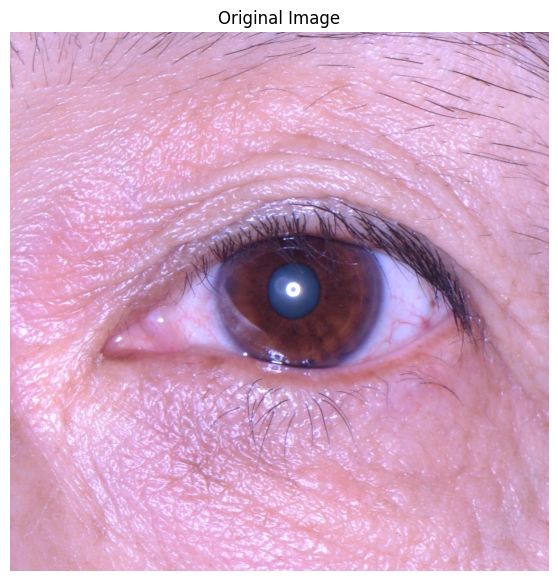

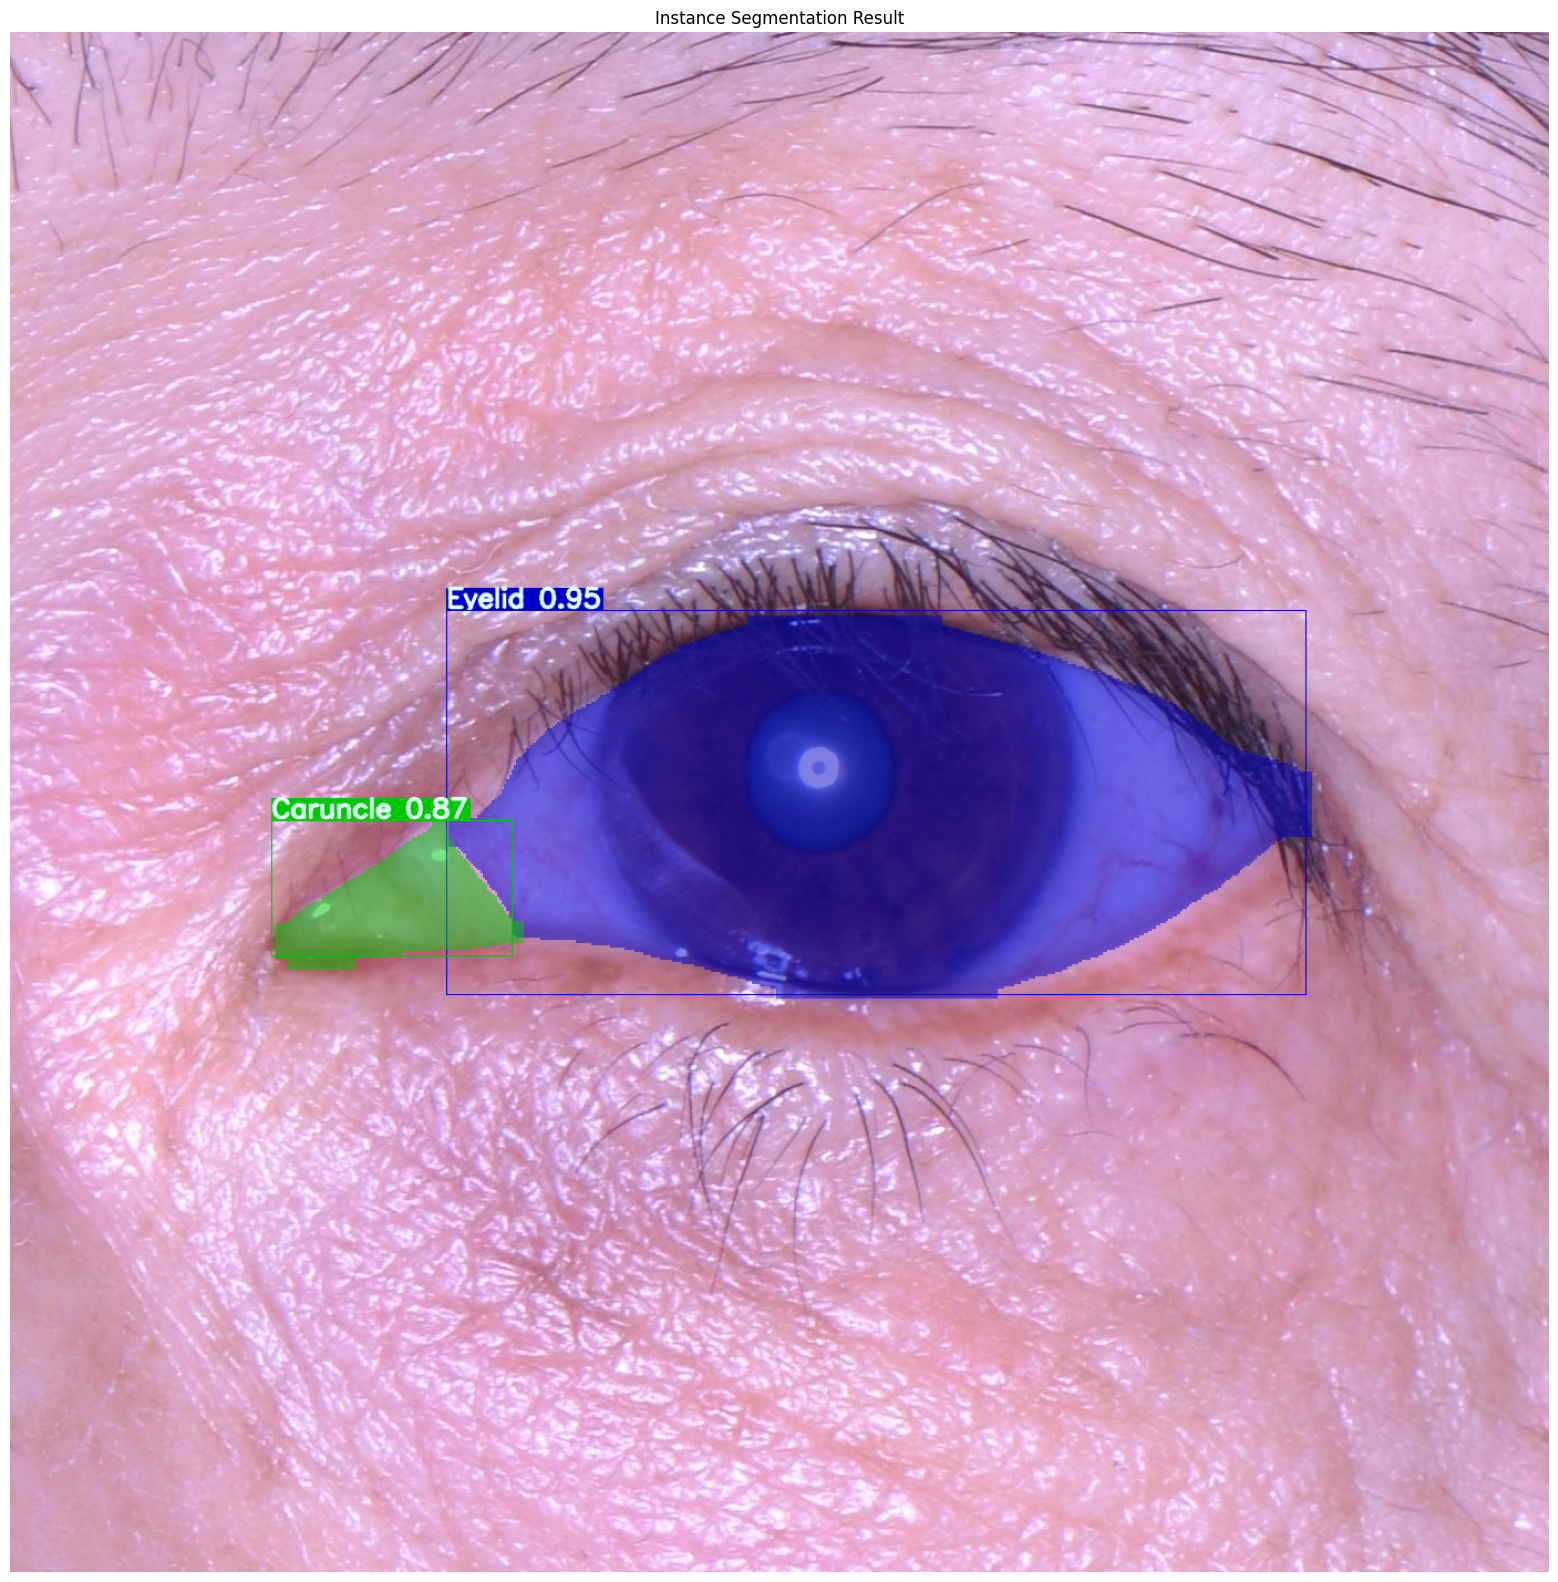

In [5]:

from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion()  # インタラクティブモードを有効化

# Load the model
model = YOLO(r"C:\Users\CorneAI\YOLOv11_Mobius\runs\segment\train26\weights\best.pt")
#model = YOLO(r"C:\Users\CorneAI\YOLOv11_Mobius\models\eyelid_caruncle_seg_1-139.pt")

# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]
linewidth = 1
fontScale = 0.8
fontFace = cv2.FONT_HERSHEY_SIMPLEX
thickness = 2

# Mask overlay function
def overlay(image, mask, color, alpha):
    """Overlay segmentation mask on the image"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    image_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    return image_combined

# Bounding box and label drawing function
def draw_label(box, img, color, label, line_thickness=3):
    """Draw bounding box and label on the image"""
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    # Draw label background
    text_size = cv2.getTextSize(
        label, fontFace, fontScale=fontScale, thickness=line_thickness
    )[0]
    cv2.rectangle(
        img, (x1, y1), (x1 + text_size[0], y1 - text_size[1] - 2), color, -1
    )  # fill
    
    # Draw label text
    cv2.putText(
        img,
        label,
        (x1, y1 - 3),
        fontFace,
        fontScale,
        [225, 255, 255],
        thickness=line_thickness,
        lineType=cv2.LINE_AA,
    )

    # Draw bounding box
    cv2.rectangle(
        img,
        (x1, y1),
        (x2, y2),
        color,
        linewidth,
    )

# Main processing function
def main():
    # Image path for inference
    image_path = r'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120119-58-094138_236eb2152cd50e23ebae4555d1c7d76f04c575dbd2d9e46f48478072a344fccc_L.jpg'
    
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get image dimensions
    h, w, _ = image.shape
    
    # Run inference with the model
    results = model(image_path, conf=0.25, iou=0.45)
    result = results[0]
    
    # Create result image (copy of original)
    output_image = image_rgb.copy()
    
    # Process if masks are available
    if result.masks is not None:
        # Confidence scores list
        conf_list = result.boxes.conf.tolist()
        
        # Process each instance
        for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
            # Resize mask to match image dimensions
            mask = cv2.resize(mask, (w, h))
            
            # Get class ID
            class_id = int(box[5]) if box.shape[0] > 5 else 0
            
            # Select color (cycle through colors if class_id exceeds color list length)
            color_idx = class_id % len(colors)
            
            # Overlay mask with semi-transparency (alpha=0.5)
            output_image = overlay(output_image, mask, colors[color_idx], 0.5)
            
            # Bounding box information
            bbox = box[:4]
            
            # Get class name
            class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
            
            # Get confidence score
            score = box[4] if box.shape[0] > 4 else conf_list[i]
            
            # Create label text
            label_text = f"{class_name} {score:.2f}"
            
            # Draw bounding box and label
            draw_label(bbox, output_image, colors[color_idx], label_text, line_thickness=2)
            
            # Output in YOLO format
            x_center = (bbox[0] + bbox[2]) / (2 * w)
            y_center = (bbox[1] + bbox[3]) / (2 * h)
            width = (bbox[2] - bbox[0]) / w
            height = (bbox[3] - bbox[1]) / h
            print(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Display results
        plt.figure(figsize=(7, 7))
        plt.title("Original Image")
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(20, 20))
        plt.title("Instance Segmentation Result")
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
        
    else:
        print("No segmentation masks found.")
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# Execute
if __name__ == "__main__":
    main()




Loading model from: C:\Users\CorneAI\YOLOv11_Mobius\runs\segment\train37\weights\best.pt
Model loaded successfully.
Loading image from: C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_3aa9e9b18a4d499388e2348362beb7b1676e93cbe55e431378c0ebfe068af9b7_R.jpg
Image loaded: width=676, height=677
Running inference...

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_3aa9e9b18a4d499388e2348362beb7b1676e93cbe55e431378c0ebfe068af9b7_R.jpg: 960x960 1 Eyelid, 1 Caruncle, 35.0ms
Speed: 5.6ms preprocess, 35.0ms inference, 2.8ms postprocess per image at shape (1, 3, 960, 960)
Inference complete.
Found 2 instances.

--- YOLO Segmentation Labels (Format: <class_id> <x1_norm> <y1_norm> <x2_norm> <y2_norm> ...) ---
0 0.349778 0.356250 0.349778 0.359375 0.348735 0.360417 0.347692 0.360417 0.346648 0.361458 0.342476 0.361458 0.341432 0.362500 0.337260 0.362500 0.336216 0.363542 0.332044 0.363542 0.331000 0.364583 0

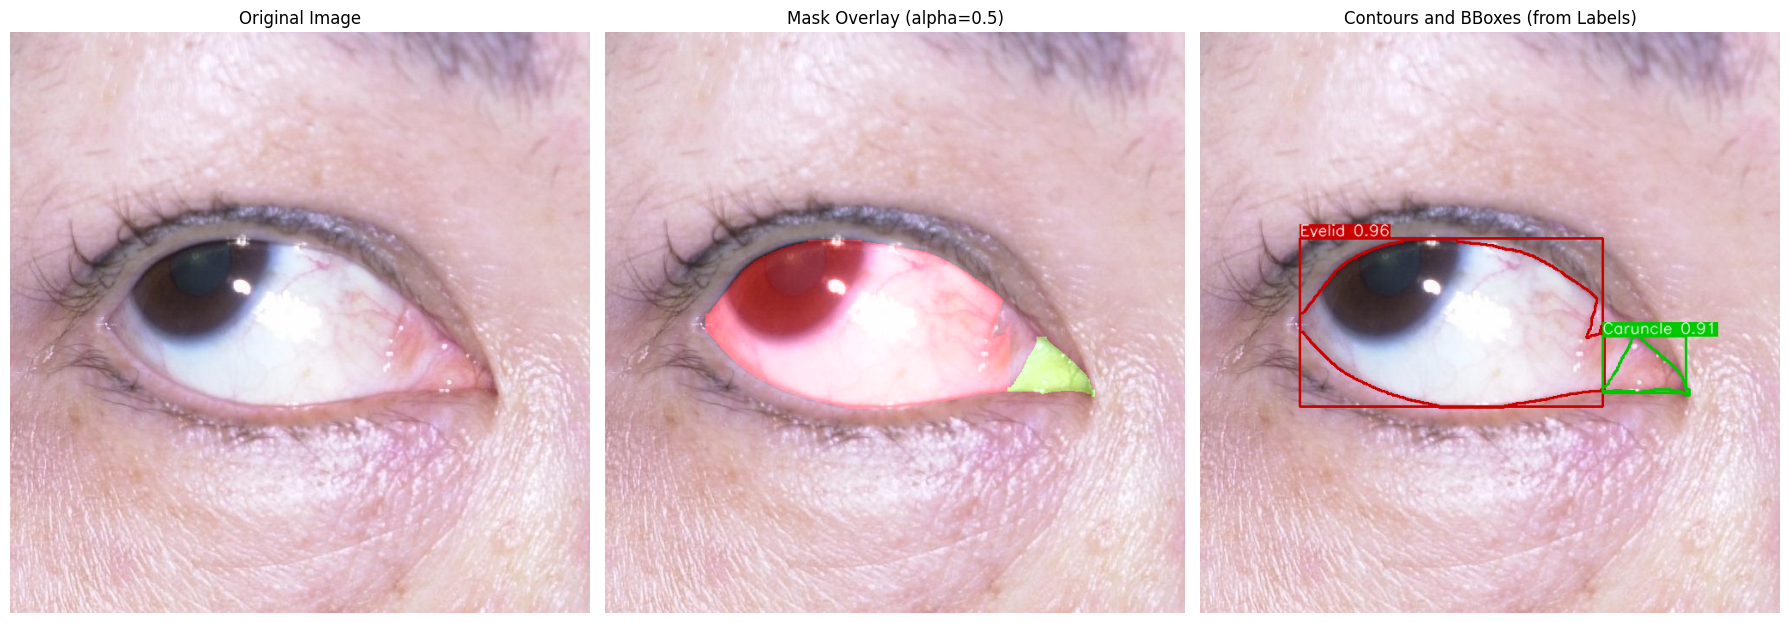

In [4]:
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os # ファイルパス操作のために追加

# %matplotlib inline # Jupyter Notebook/Lab 環境以外では不要な場合が多い
# plt.ion()  # インタラクティブモードを有効化 (スクリプト実行では不要な場合が多い)

# --- 設定 ---
# モデルファイルのパス
MODEL_PATH = r"C:\Users\CorneAI\YOLOv11_Mobius\runs\segment\train37\weights\best.pt"
# 推論対象の画像パス
IMAGE_PATH = r'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_3aa9e9b18a4d499388e2348362beb7b1676e93cbe55e431378c0ebfe068af9b7_R.jpg'
# 推論パラメータ
CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.45
# 描画設定
COLORS = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)] # BGR
LINEWIDTH = 2 # 輪郭線とbboxの太さ
FONT_SCALE = 0.6
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
THICKNESS = 1 # 文字の太さ
ALPHA = 0.5 # マスクの透明度
# --- 設定ここまで ---

# Load the model
print(f"Loading model from: {MODEL_PATH}")
model = YOLO(MODEL_PATH)
print("Model loaded successfully.")

# Mask overlay function
def overlay(image, mask, color, alpha):
    """Overlay segmentation mask on the image"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[mask == 1] = color # マスク部分のみ色付け

    # Apply transparency
    # cv2.addWeightedを使って合成
    image_combined = cv2.addWeighted(image, 1.0, colored_mask, alpha, 0)

    # マスク部分のみオーバーレイする方法 (別の実装例)
    # image_overlay = image.copy()
    # image_overlay[mask == 1] = cv2.addWeighted(image[mask == 1], 1 - alpha, colored_mask[mask == 1], alpha, 0)
    # return image_overlay
    return image_combined

# Bounding box, label, and contour drawing function
def draw_detections(img, box, mask_contour_points, color, label, line_thickness=2):
    """Draw bounding box, label, and segmentation contour on the image"""
    x1, y1, x2, y2 = map(int, box[:4])
    h, w = img.shape[:2] # Get image dimensions for denormalization

    # --- Draw Label ---
    text_size, _ = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    # Ensure label background is within image bounds
    text_bg_x1 = x1
    text_bg_y1 = max(0, y1 - text_size[1] - 2) # Adjust if label goes above image
    text_bg_x2 = x1 + text_size[0]
    text_bg_y2 = y1 # y1 is the top of the box
    cv2.rectangle(img, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)  # fill
    # Draw label text (white color for better contrast on colored background)
    cv2.putText(img, label, (x1, y1 - 3), FONT_FACE, FONT_SCALE, [255, 255, 255], thickness=THICKNESS, lineType=cv2.LINE_AA)
    # --- End Draw Label ---

    # --- Draw Bounding Box ---
    cv2.rectangle(img, (x1, y1), (x2, y2), color, line_thickness)
    # --- End Draw Bounding Box ---

    # --- Draw Segmentation Contour ---
    if mask_contour_points is not None and len(mask_contour_points) > 0:
        # Denormalize contour points (multiply by image width and height)
        contour = (mask_contour_points * np.array([w, h])).astype(np.int32)
        # Reshape for cv2.polylines which expects a list of contours
        contour = contour.reshape((-1, 1, 2))
        cv2.polylines(img, [contour], isClosed=True, color=color, thickness=line_thickness)
    # --- End Draw Segmentation Contour ---


# Main processing function
def main():
    # --- 1. Load Image ---
    print(f"Loading image from: {IMAGE_PATH}")
    if not os.path.exists(IMAGE_PATH):
        print(f"Error: Image file not found at {IMAGE_PATH}")
        return
    image_bgr = cv2.imread(IMAGE_PATH)
    if image_bgr is None:
        print(f"Error: Could not read image file {IMAGE_PATH}")
        return
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = image_bgr.shape
    print(f"Image loaded: width={w}, height={h}")

    # --- 2. Run Inference ---
    print("Running inference...")
    results = model(IMAGE_PATH, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD)
    result = results[0] # Get the first result (assuming single image inference)
    print("Inference complete.")

    # --- 3. Process Results and Generate Labels/Visualization ---
    output_image_overlay = image_rgb.copy() # For mask overlay
    output_image_contour = image_rgb.copy() # For contour drawing
    yolo_seg_labels = [] # To store YOLO segmentation format labels

    if result.masks is not None and len(result.masks) > 0:
        print(f"Found {len(result.masks)} instances.")
        # Get normalized contour coordinates for all masks
        # result.masks.xyn is a list where each element is a numpy array of shape (N, 2)
        # representing the normalized (x, y) coordinates of the contour points for one mask.
        normalized_contours = result.masks.xyn

        # Confidence scores list
        conf_list = result.boxes.conf.tolist()
        # Class IDs list
        cls_list = result.boxes.cls.tolist()
        # Bounding boxes list (xyxy format)
        boxes_list = result.boxes.xyxy.cpu().numpy()

        # Process each detected instance
        for i in range(len(result.masks)):
            mask_data = result.masks.data[i].cpu().numpy() # Get mask data for overlay
            box = boxes_list[i]
            norm_contour = normalized_contours[i] # Get normalized contour points for this instance
            class_id = int(cls_list[i])
            score = conf_list[i]

            # Resize mask for overlay (if needed - overlay function handles it)
            # Note: It's usually better to work with contours for YOLO format
            mask_resized = cv2.resize(mask_data, (w, h), interpolation=cv2.INTER_NEAREST)

            # Select color
            color_idx = class_id % len(COLORS)
            color_bgr = COLORS[color_idx]
            # Convert color to RGB for matplotlib display consistency if needed
            # color_rgb = tuple(reversed(color_bgr)) # For imshow

            # --- a) Generate YOLO Segmentation Label ---
            # Flatten the normalized contour coordinates [x1, y1, x2, y2, ...]
            contour_flat = norm_contour.flatten()
            # Format the coordinates as strings
            contour_str = " ".join([f"{coord:.6f}" for coord in contour_flat])
            # Create the YOLO segmentation label string: <class_id> <x1> <y1> <x2> <y2> ...
            yolo_label_line = f"{class_id} {contour_str}"
            yolo_seg_labels.append(yolo_label_line)

            # --- b) Prepare Visualization ---
            class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
            label_text = f"{class_name} {score:.2f}"

            # Apply mask overlay to one image
            output_image_overlay = overlay(output_image_overlay, mask_resized, tuple(reversed(color_bgr)), ALPHA) # Use RGB for overlay on RGB image

            # Draw bounding box, label, and contour on the other image
            draw_detections(output_image_contour, box, norm_contour, tuple(reversed(color_bgr)), label_text, line_thickness=LINEWIDTH) # Use RGB for drawing

        # --- 4. Output YOLO Labels ---
        print("\n--- YOLO Segmentation Labels (Format: <class_id> <x1_norm> <y1_norm> <x2_norm> <y2_norm> ...) ---")
        for label_line in yolo_seg_labels:
            print(label_line)
        print("----------------------------------------------------------------------------------------------")

        # (Optional) Save YOLO labels to a .txt file
        # Construct the output label file path (same directory and name as image, but .txt extension)
        label_filename = os.path.splitext(os.path.basename(IMAGE_PATH))[0] + '.txt'
        output_label_path = os.path.join(os.path.dirname(IMAGE_PATH), label_filename)
        try:
            with open(output_label_path, 'w') as f:
                for line in yolo_seg_labels:
                    f.write(line + '\n')
            print(f"Saved YOLO segmentation labels to: {output_label_path}")
        except Exception as e:
            print(f"Error saving label file '{output_label_path}': {e}")

        # --- 5. Display Results ---
        plt.figure(figsize=(18, 8)) # Increased figure size

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image_rgb)
        plt.axis('off')

        # Image with Mask Overlay
        plt.subplot(1, 3, 2)
        plt.title(f"Mask Overlay (alpha={ALPHA})")
        plt.imshow(output_image_overlay)
        plt.axis('off')

        # Image with Contours and BBoxes
        plt.subplot(1, 3, 3)
        plt.title("Contours and BBoxes (from Labels)")
        plt.imshow(output_image_contour)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # (Optional) Save the result images
        # output_overlay_filename = os.path.splitext(IMAGE_PATH)[0] + "_overlay.jpg"
        # output_contour_filename = os.path.splitext(IMAGE_PATH)[0] + "_contours.jpg"
        # cv2.imwrite(output_overlay_filename, cv2.cvtColor(output_image_overlay, cv2.COLOR_RGB2BGR))
        # cv2.imwrite(output_contour_filename, cv2.cvtColor(output_image_contour, cv2.COLOR_RGB2BGR))
        # print(f"Saved overlay result: {output_overlay_filename}")
        # print(f"Saved contour result: {output_contour_filename}")

    else:
        print("No segmentation masks found in the results.")
        # Display the original image if no detections
        plt.figure(figsize=(8, 8))
        plt.imshow(image_rgb)
        plt.title("Original Image (No Detections)")
        plt.axis('off')
        plt.show()
        # Optionally display the result plot even if only bboxes are present (if applicable)
        # if hasattr(result, 'plot'):
        #     print("Displaying result plot (may contain bounding boxes only)...")
        #     plt.figure(figsize=(12, 8))
        #     plt.imshow(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))
        #     plt.axis('off')
        #     plt.show()

# Execute the main function
if __name__ == "__main__":
    main()
    # plt.ioff() # Turn off interactive mode if it was turned on
    # plt.show(block=True) # Ensure plots stay open in some environments if needed

# **Create XML file for uploading predictions on CVAT**

In [22]:
import xml.etree.ElementTree as ET
import os
import cv2
import numpy as np
from ultralytics import YOLO
import time
import copy # 範囲外の要素を安全にコピーするために使用
import zipfile # ZIPファイル作成のために追加

# --- 設定 ---
start_id = 501
end_id = 1000
orig_xml_path = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\annotations_1-139.xml" # 元のCVAT XML
dest_xml_path = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\annotations_for_cvat.xml" # 新たに作成するXML (ファイル名変更推奨)
Image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images" # 画像が格納されているディレクトリ
MODEL_PATH = r"C:\Users\CorneAI\YOLOv11_Mobius\models\eyelid_caruncle_seg_1-139.pt" # YOLOモデルのパス
ZIP_compression = True # XMLファイルをZIP圧縮するかどうか

# 推論パラメータ
CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.45

# 処理対象とするクラス名 (XMLのラベル名と一致させる)
TARGET_CLASSES = {"Eyelid", "Caruncle"}
# 予測結果のポリゴンに付けるsource属性の値
PREDICTION_SOURCE = "prediction" # predictionであることを示すsource
# --- 設定ここまで ---

def format_points_for_cvat(points_array):
    """Numpy配列の座標リストをCVATのpoints属性文字列に変換"""
    if points_array is None or len(points_array) == 0:
        return ""
    # 各座標を "x.xx,y.yy" 形式の文字列にし、セミコロンで結合
    return ";".join([f"{x:.2f},{y:.2f}" for x, y in points_array])

def main():
    print("--- Workflow Start (Overwrite Annotations in Range + Keep Others) ---")
    print(f"Overwriting annotations for image IDs {start_id} to {end_id}")
    print(f"Source XML: {orig_xml_path}")
    print(f"Image Directory: {Image_dir}")
    print(f"Model Path: {MODEL_PATH}")
    print(f"Output XML: {dest_xml_path}")
    if ZIP_compression:
        print("ZIP compression: Enabled")
    print("-" * 30)

    # --- 1. Load YOLO Model ---
    try:
        print("Loading YOLO model...")
        model = YOLO(MODEL_PATH)
        class_names = model.names
        print(f"Model loaded successfully. Class names: {class_names}")
    except Exception as e:
        print(f"Error loading YOLO model: {e}")
        return

    # --- 2. Parse Original XML ---
    try:
        print("Parsing original XML...")
        if not os.path.exists(orig_xml_path):
            raise FileNotFoundError(f"Original XML file not found: {orig_xml_path}")
        original_tree = ET.parse(orig_xml_path)
        original_root = original_tree.getroot()
        print("Original XML parsed.")
    except FileNotFoundError as e:
        print(e)
        return
    except ET.ParseError as e:
        print(f"Error parsing XML: {e}")
        return

    # --- 3. Create New XML Structure ---
    print("Creating new XML structure...")
    new_root = ET.Element(original_root.tag) # <annotations>

    # Copy <version> and <meta> using deepcopy for safety
    version_element = original_root.find('version')
    if version_element is not None:
        new_root.append(copy.deepcopy(version_element))
    meta_element = original_root.find('meta')
    if meta_element is not None:
        new_root.append(copy.deepcopy(meta_element))
    else:
        print("Warning: <meta> tag not found in original XML.")

    # --- 4. Process Images ---
    processed_image_count = 0 # 新しいXMLに追加された<image>要素の数
    overwritten_image_count = 0 # アノテーションが上書きされた画像の数
    kept_image_count = 0 # アノテーションが維持された画像の数
    skipped_for_overwrite_count = 0 # 上書き対象だったがスキップされた数
    total_inference_time = 0
    total_images_in_xml = len(original_root.findall('image'))

    print(f"Iterating through {total_images_in_xml} images in original XML...")
    for image_element in original_root.findall('image'):
        image_id_str = image_element.get('id')
        image_name = image_element.get('name', 'N/A')

        if image_id_str is None:
            print(f"Warning: Skipping <image> element without 'id' attribute (name: {image_name}).")
            continue

        try:
            image_id = int(image_id_str)

            # --- Check if image ID is within the target range for overwriting ---
            if start_id <= image_id <= end_id:
                # --- Image ID is in range: Overwrite annotations ---
                print(f"\nProcessing Image ID: {image_id}, Name: {image_name} (Overwrite target)")

                # --- Create a new <image> element with original attributes BUT NO children (annotations) ---
                new_image_element = ET.Element('image', attrib=image_element.attrib)
                # ここでは元の <polygon> などをコピーしない

                # --- Get necessary info for prediction ---
                image_width_str = image_element.get('width')
                image_height_str = image_element.get('height')
                if not all([image_name, image_width_str, image_height_str]):
                    print(f"  Warning: Missing attributes (name, width, or height). Skipping prediction. Empty image tag added.")
                    skipped_for_overwrite_count += 1
                    # Add the empty image element to the new root
                    new_root.append(new_image_element)
                    processed_image_count += 1
                    continue # Skip to the next image element

                image_width = int(image_width_str)
                image_height = int(image_height_str)
                image_path = os.path.join(Image_dir, image_name)

                # --- Check Image Existence for Prediction ---
                if not os.path.exists(image_path):
                    print(f"  Warning: Image file not found at {image_path}. Cannot perform prediction. Empty image tag added.")
                    skipped_for_overwrite_count += 1
                    # Add the empty image element to the new root
                    new_root.append(new_image_element)
                    processed_image_count += 1
                    continue # Skip to the next image element

                # --- Run YOLO Inference ---
                overwritten_image_count += 1 # Count as actually attempting overwrite
                try:
                    start_time = time.time()
                    results = model(image_path, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD, verbose=False)
                    inference_time = time.time() - start_time
                    total_inference_time += inference_time
                    print(f"  Inference completed in {inference_time:.3f} seconds.")

                    result = results[0]

                    # --- Extract Predicted Polygons and Add to the NEW (empty) <image> element ---
                    predicted_polygon_count = 0
                    if result.masks is not None and len(result.masks) > 0:
                        normalized_contours = result.masks.xyn
                        cls_list = result.boxes.cls.tolist()

                        for i in range(len(result.masks)):
                            class_id = int(cls_list[i])
                            detected_class_name = class_names.get(class_id, f"Unknown_{class_id}")

                            if detected_class_name in TARGET_CLASSES:
                                norm_contour = normalized_contours[i]
                                abs_contour = (norm_contour * np.array([image_width, image_height])).astype(np.float32)
                                points_str = format_points_for_cvat(abs_contour)

                                if points_str:
                                    polygon_attribs = {
                                        "label": detected_class_name,
                                        "source": PREDICTION_SOURCE, # Mark as prediction/overwrite
                                        "occluded": "0",
                                        "points": points_str,
                                        "z_order": "0"
                                    }
                                    # Add the new polygon to the new_image_element
                                    ET.SubElement(new_image_element, 'polygon', attrib=polygon_attribs)
                                    predicted_polygon_count += 1

                        print(f"  Added {predicted_polygon_count} predicted polygon(s) (overwriting previous).")
                    else:
                        print("  No masks found in prediction results. Image tag added without annotations.")

                    # Add the new_image_element (containing only predictions) to the new root
                    new_root.append(new_image_element)
                    processed_image_count += 1

                except Exception as infer_err:
                    print(f"  Error during inference or processing prediction for image ID {image_id}: {infer_err}")
                    print("  Adding empty image tag due to error.")
                    skipped_for_overwrite_count += 1
                    # Add the empty image element in case of error during prediction
                    new_root.append(ET.Element('image', attrib=image_element.attrib))
                    processed_image_count += 1

            else:
                # --- Image ID is outside the range: Keep original annotations ---
                # print(f"Image ID: {image_id}, Name: {image_name} (Outside overwrite range, copying original)")
                # Deepcopy the entire original <image> element and its children
                new_root.append(copy.deepcopy(image_element))
                kept_image_count += 1
                processed_image_count += 1

        except ValueError as e:
            print(f"Warning: Skipping image element due to invalid ID or dimensions (ID: {image_id_str}, Name: {image_name}): {e}")
        except Exception as e:
            print(f"An unexpected error occurred while processing image ID {image_id_str} (Name: {image_name}): {e}")


    print("-" * 30)
    print(f"Finished processing. Summary:")
    print(f"Total images from original XML: {total_images_in_xml}")
    print(f"Total images included in the new XML: {processed_image_count}")
    print(f"Images where annotations were overwritten by predictions: {overwritten_image_count}")
    print(f"Images skipped for overwrite (file not found, error, etc.): {skipped_for_overwrite_count}")
    print(f"Images where original annotations were kept (outside range): {kept_image_count}")
    print(f"Total inference time (for {overwritten_image_count} images): {total_inference_time:.2f} seconds")
    if overwritten_image_count > 0:
        print(f"Average inference time per overwritten image: {total_inference_time / overwritten_image_count:.3f} seconds")

    # --- 5. Save New XML and Optionally Create ZIP ---
    if processed_image_count > 0:
        print(f"Saving new annotations to: {dest_xml_path}")
        new_tree = ET.ElementTree(new_root)

        try:
            ET.indent(new_tree, space="  ", level=0)
        except AttributeError:
            print("Warning: ET.indent not available (requires Python 3.9+). XML will not be pretty-printed.")

        dest_dir = os.path.dirname(dest_xml_path)
        if dest_dir and not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
            print(f"Created destination directory: {dest_dir}")

        xml_saved = False
        try:
            new_tree.write(dest_xml_path, encoding='utf-8', xml_declaration=True)
            print("New XML file saved successfully.")
            xml_saved = True
        except Exception as e:
            print(f"Error writing XML file: {e}")

        # --- Create ZIP file if requested and XML was saved ---
        if xml_saved and ZIP_compression:
            zip_file_path = os.path.splitext(dest_xml_path)[0] + ".zip"
            print(f"Creating ZIP archive: {zip_file_path}")
            try:
                with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
                    # Add the XML file to the zip archive using its base name
                    zipf.write(dest_xml_path, arcname=os.path.basename(dest_xml_path))
                print("ZIP archive created successfully.")
            except Exception as e:
                print(f"Error creating ZIP file: {e}")

    else:
        print("No image elements were processed to be included in the new XML. Output file not generated.")

    print("--- Workflow End ---")

if __name__ == "__main__":
    main()

--- Workflow Start (Overwrite Annotations in Range + Keep Others) ---
Overwriting annotations for image IDs 501 to 1000
Source XML: C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\annotations_1-139.xml
Image Directory: C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images
Model Path: C:\Users\CorneAI\YOLOv11_Mobius\models\eyelid_caruncle_seg_1-139.pt
Output XML: C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\annotations_for_cvat.xml
ZIP compression: Enabled
------------------------------
Loading YOLO model...
Model loaded successfully. Class names: {0: 'Eyelid', 1: 'Caruncle'}
Parsing original XML...
Original XML parsed.
Creating new XML structure...
Iterating through 4464 images in original XML...

Processing Image ID: 501, Name: 14-20190604-77-111937_9391b3f869f19372da08665560d681a75a00a0808d6dfa7231bd7038216a968a_L.jpg (Overwrite target)
  Inference completed in 1.031 seconds.
  Added 2 predicted polygon(s) (overwriting previous).

Process